The goal of this script is to get all the unique substrates from a file and then try to filter out co-factors and other co-substrates.<br/><br/>Copyright (C) 2017  Martin Engqvist Lab<br/>This program is free software: you can redistribute it and/or modify<br/>it under the terms of the GNU General Public License as published by<br/>the Free Software Foundation, either version 3 of the License, or<br/>(at your option) any later version.<br/>This program is distributed in the hope that it will be useful,<br/>but WITHOUT ANY WARRANTY; without even the implied warranty of<br/>MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the<br/>GNU General Public License for more details.<br/>You should have received a copy of the GNU General Public License<br/>along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from os.path import join, dirname, basename, exists, isdir

### Load environmental variables from the project root directory ###
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

# now you can get the variables using their names

# Check whether a network drive has been specified
DATABASE = os.environ.get("NETWORK_URL")
if DATABASE == 'None':
    pass
else:
    pass
    #mount network drive here

# set up directory paths
CURRENT_DIR = os.getcwd()
PROJ = dirname(dotenv_path) # project root directory

DATA = join(PROJ, 'data') #data directory
RAW_EXTERNAL = join(DATA, 'raw_external') # external data raw directory
RAW_INTERNAL = join(DATA, 'raw_internal') # internal data raw directory
INTERMEDIATE = join(DATA, 'intermediate') # intermediate data directory
FINAL = join(DATA, 'final') # final data directory

RESULTS = join(PROJ, 'results') # output directory
FIGURES = join(RESULTS, 'figures') # figure output directory
PICTURES = join(RESULTS, 'pictures') # picture output directory


# make folders specific for certain data
folder_name = 'brenda_data_2019_1'
if folder_name != '':
    #make folders if they don't exist
    if not exists(join(RAW_EXTERNAL, folder_name)):
        os.makedirs(join(RAW_EXTERNAL, folder_name))

    if not exists(join(INTERMEDIATE, folder_name)):
        os.makedirs(join(INTERMEDIATE, folder_name))

    if not exists(join(FINAL, folder_name)):
        os.makedirs(join(FINAL, folder_name))

print('Standard variables loaded, you are good to go!')

Standard variables loaded, you are good to go!


First I need to download the BRENDA data

In [2]:
import json
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import re


In [3]:
def parse_substrates(filepath):
    '''
    Parse the substrate data
    Return dictionary with EC number keys holding lists of substrates.
    '''
    with open(filepath, 'r') as f:
        in_data = json.loads(f.read())

    out_data = {}
    for ec in sorted(in_data.keys()):
        out_data[ec] = {'substrates':[], 'reaction_substrates':[], 'reaction_products':[]}
        for item in in_data[ec].split('#'):
            
            if item.startswith(u'substrate'):
                substrate = item.replace(u'substrate*', u'').strip()
                out_data[ec]['substrates'].append(re.sub('^[0-9]+?[ ]', '', substrate))
                
            elif item.startswith(u'reactionPartners'):
                reaction = item.replace(u'reactionPartners*', u'')
                try:
                    reactants, products = reaction.split('=')
                except:
                    reactants = reaction
                    products = ''
                    
                out_data[ec]['reaction_substrates'].append([re.sub('^[0-9]+?[ ]', '', i.strip()) for i in reactants.split(' + ')])
                out_data[ec]['reaction_products'].append([re.sub('^[0-9]+?[ ]', '', i.strip()) for i in products.split(' + ')])


    return out_data


def parse_natural_substrates(filepath):
    '''
    Parse the natural substrate data
    Return dictionary with EC number keys holding list of lists of substrates.
    The innermost lists hold the substrates of a single reaction (one enzyme).
    The outer lits holds many inner lists.
    '''
    with open(filepath, 'r') as f:
        in_data = json.loads(f.read())

    out_data = {}
    for ec in sorted(in_data.keys()):
        out_data[ec] = {'substrates':[], 'reaction_substrates':[], 'reaction_products':[]}
        for item in in_data[ec].split('#'):
            
            if item.startswith(u'naturalSubstrate'):
                substrate = item.replace(u'naturalSubstrate*', u'').strip()
                out_data[ec]['substrates'].append(re.sub('^[0-9]+?[ ]', '', substrate))
                
            elif item.startswith(u'naturalReactionPartners'):
                reaction = item.replace(u'naturalReactionPartners*', u'')
                try:
                    reactants, products = reaction.split('=')
                except:
                    reactants = reaction
                    products = ''
                    
                out_data[ec]['reaction_substrates'].append([re.sub('^[0-9]+?[ ]', '', i.strip()) for i in reactants.split(' + ')])
                out_data[ec]['reaction_products'].append([re.sub('^[0-9]+?[ ]', '', i.strip()) for i in products.split(' + ')])

    return out_data



The goal here is to identify co-factors and co-substrates in reactions so that they can be removed before a substrate promiscuity score is calculated. For example, I don't want compare O2 with glycolate in EC 1.1.3.15, the oxygen should be removed from the analysis. Things to filter might be NAD+, NADH, NADP+, NADPH, H2O, CO2, O2, NH4, H+, 2,6-dichloroindophenol, phenazine methosulfate, more, etc.

There are two hypothesis underlying their identification in this analysis: A) Due to the hierarchical nature of EC numbers, with the last digit denoting substrate specificity, a co-factor or uninteresting co-substrate should be present in almost all EC numbers below any given EC3 level (for example 1.1.1.n). B) An uninteresting co-substrate or co-enzyme should also be a member of a majority of the recorded reactions for a given EC class.

In [5]:

def get_ec_4_unique_molecules(data, typeof='substrate'):
    '''
    Get all the unique substrates from each EC class
    '''
    substrates = {}
    
    if typeof == 'substrate':
        dict_key = 'reaction_substrates'
    elif typeof == 'product':
        dict_key = 'reaction_products'
    else:
        raise ValueError
    
    for ec in sorted(data.keys()):
        substrates[ec] = []
        for r in data[ec][dict_key]:
            substrates[ec].extend([re.sub('^[0-9]+?[ ]', '', s) for s in r])
        substrates[ec] = set(substrates[ec])

    return substrates



def count_ec_4_molecule_occurance(data, typeof='substrate'):
    '''
    For each EC, get all the unique substrates or products and calculate 
    in what percentage of reactions (for that EC) the molecule occurs.
    '''
    unique_dict = get_ec_4_unique_molecules(data, typeof)
    
    if typeof == 'substrate':
        dict_key = 'reaction_substrates'
    elif typeof == 'product':
        dict_key = 'reaction_products'
    else:
        raise ValueError
    
    out_data = {}
    for ec in sorted(data.keys()):
        out_data[ec] = {}
        
        # initialize a count of 0 for each substrate
        counter = {k:0 for k in unique_dict[ec]}
        
        total_reactions = 0
        for r in data[ec][dict_key]:
            total_reactions += 1
            
            for substrate in counter.keys():
                if substrate in r:
                    counter[substrate] += 1
                    
        # now compute the percentage
        for substrate in counter.keys():     
            out_data[ec][substrate] = round(100 * counter[substrate] / float(total_reactions), 2)

    return out_data
    

    
def count_occurance_of_molecule_across_ec3_and_ec4_classes(data, typeof='substrate'):
    '''
    For each EC3 class (for example 1.1.1.n), get all the unique substrates or products and calculate 
    in what percentage of EC4 classes that molecule occurs.
    '''
    unique_dict = get_ec_4_unique_molecules(data, typeof)
    
    if typeof == 'substrate':
        dict_key = 'reaction_substrates'
    elif typeof == 'product':
        dict_key = 'reaction_products'
    else:
        raise ValueError
    
    # first group the EC numbers into EC3 categories
    ec3_dict = {}
    for ec in sorted(unique_dict.keys()):
        ec3 = '.'.join(ec.split('.')[:3])

        if ec3_dict.get(ec3) is None:
            ec3_dict[ec3] = []
            
        ec3_dict[ec3].append(ec)

        
    # now go through each molecule occuring in EC4 categories and compute 
    # in what percentage of the other EC3 categories they occur
    out_data = {}
    for ec in sorted(data.keys()):
        ec3 = '.'.join(ec.split('.')[:3])
        
        out_data[ec] = {}
        
        # initialize a count of 0 for each substrate
        ec3_counter = {k:0 for k in unique_dict[ec]}

        
        # count occurance in all neighboring EC3 classes
        total_ec3_classes = 0
        for ec4 in sorted(ec3_dict[ec3]):
            total_ec3_classes += 1

            for substrate in ec3_counter.keys():
                if substrate in unique_dict[ec4]:
                    ec3_counter[substrate] += 1

        # now compute the percentage, but only if there are at least 10 subclasses
        for substrate in ec3_counter.keys():     
            out_data[ec][substrate] = {}
            if total_ec3_classes >= 10:
                out_data[ec][substrate]['3'] = round(100 * ec3_counter[substrate] / float(total_ec3_classes), 2)
            else:
                out_data[ec][substrate]['3'] = 0.0
            
                    
        # initialize a count of 0 for each substrate
        ec4_counter = {k:0 for k in unique_dict[ec]}                    
                    
        # count occurrance in all EC4 classes
        total_ec4_classes = 0
        for ec4 in sorted(data.keys()):
            total_ec4_classes += 1

            for substrate in ec4_counter.keys():
                if substrate in unique_dict[ec4]:
                    ec4_counter[substrate] += 1
                    
        # now compute the percentage
        for substrate in ec4_counter.keys():     
            out_data[ec][substrate]['4'] = round(100 * ec4_counter[substrate] / float(total_ec4_classes), 2)

    return out_data
    



def write_outfile(filepath, within_own_ec4, between_classes, typeof='substrate'):
    '''
    Write data to a flatfile
    '''
    out_lines = ['ec\t%s\toccurance_in_own_EC4_reactions\toccurance_in_neighbor_EC3_subclasses\ttoccurance_across_EC4_classes' % (typeof)]
    for ec in sorted(within_own_ec4.keys()):
        for molecule in sorted(within_own_ec4[ec].keys()):
            own_percent = within_own_ec4[ec][molecule]
            ec3_percent = between_classes[ec][molecule]['3']
            ec4_percent = between_classes[ec][molecule]['4']
            out_lines.append('%s\t%s\t%s\t%s\t%s' % (ec, molecule, own_percent, ec3_percent, ec4_percent))
            
    with open(filepath, 'w') as f:
        f.write('\n'.join(out_lines))
        
        

    

# parse the substrate data files
subst = parse_substrates(filepath=join(RAW_EXTERNAL, folder_name, 'substrates_data.txt'))
nat_subst = parse_natural_substrates(filepath=join(RAW_EXTERNAL, folder_name, 'natural_substrates_data.txt'))


# compute substarte occurances   
within_self = count_ec_4_molecule_occurance(nat_subst, typeof='substrate')
between_classes = count_occurance_of_molecule_across_ec3_and_ec4_classes(nat_subst, typeof='substrate')


out_filepath = join(INTERMEDIATE, folder_name, 'scored_substrates.tsv')
write_outfile(out_filepath, within_self, between_classes)


1.1.1.1 (-)-carvone
1.1.1.1 (1S,3S)-3-methylcyclohexanol
1.1.1.1 (2E)-2-methylpent-2-enal
1.1.1.1 (2E)-3,7-dimethylocta-2,6-dienal
1.1.1.1 (2E)-but-2-en-1-ol
1.1.1.1 (2E)-but-2-enal
1.1.1.1 (2E)-dec-2-enal
1.1.1.1 (2E)-hex-2-enal
1.1.1.1 (2E)-oct-2-enal
1.1.1.1 (6S)-5,6-dihydro-6-methyl-4H-thieno[2,3b]thiopyran-4-one-7,7-dioxide
1.1.1.1 (E)-hex-2-en-1-ol
1.1.1.1 (R)-1-indanol
1.1.1.1 (R)-2-butanol
1.1.1.1 (R)-2-heptanol
1.1.1.1 (R)-2-hexanol
1.1.1.1 (R)-2-octanol
1.1.1.1 (R)-2-pentanol
1.1.1.1 (R)-2-phenylpropanol
1.1.1.1 (R)-3-methylcyclohexanone
1.1.1.1 (R)-alpha-tetralol
1.1.1.1 (R,S)-2-methylbutan-1-ol
1.1.1.1 (S)-(+)-1-indanol
1.1.1.1 (S)-1-indanol
1.1.1.1 (S)-1-phenyl-2-propanol
1.1.1.1 (S)-1-phenylethanol
1.1.1.1 (S)-2-butanol
1.1.1.1 (S)-2-heptanol
1.1.1.1 (S)-2-hexanol
1.1.1.1 (S)-2-methylbutan-1-ol
1.1.1.1 (S)-2-octanol
1.1.1.1 (S)-2-pentanol
1.1.1.1 (S)-2-phenylpropanol
1.1.1.1 (S)-4-phenylbutan-2-ol
1.1.1.1 (S)-alpha-tetralol
1.1.1.1 (S)-heptan-2-ol
1.1.1.1 (S)-pentan-2-ol


1.1.1.150 17-hydroxy-pregn-4-ene-3,20,21-trione
1.1.1.150 5beta-pregnane-3alpha,21-diol-20-one
1.1.1.150 NAD+
1.1.1.150 NADH
1.1.1.150 dihydrotestosterone
1.1.1.150 more
1.1.1.150 pregn-4-ene-3,20,21-trione
1.1.1.151 11beta,17-dihydroxy-pregn-4,11-diene-3,20,21-trione
1.1.1.151 11beta,17-dihydroxy-pregn-4-ene-3,20,21-trione
1.1.1.151 11beta-hydroxy-pregn-4-ene-3,20,21-trione
1.1.1.151 17-hydroxy-pregn-4-ene-3,20,21-trione
1.1.1.151 17alpha-hydroxy-pregn-4-ene-3,11,20,21-tetraone
1.1.1.151 NADPH
1.1.1.151 pregn-4-ene-3,20,21-trione
1.1.1.152 3alpha-hydroxy-5beta-androstane-17-one
1.1.1.152 NAD+
1.1.1.153 1'-hydroxy-2'-oxopropyltetrahydropterin
1.1.1.153 1'-oxo-2'-D-hydroxypropyl-tetrahydropterin
1.1.1.153 1'-oxo-2'-L-hydroxypropyl-tetrahydropterin
1.1.1.153 1,2-cyclohexadione
1.1.1.153 1,2-naphthoquinone
1.1.1.153 1,4-naphthoquinone
1.1.1.153 1-phenyl-1,2-propanedione
1.1.1.153 2,3-butanediol
1.1.1.153 2,3-dimethoxynaphthalene-1,4-dione
1.1.1.153 2,4-pentanedione
1.1.1.153 6-(S)-lactoyl

1.1.1.21 L-sorbose
1.1.1.21 L-threose
1.1.1.21 L-xylose
1.1.1.21 NAD(P)+
1.1.1.21 NAD(P)H
1.1.1.21 NAD+
1.1.1.21 NADH
1.1.1.21 NADP+
1.1.1.21 NADPH
1.1.1.21 acetaldehyde
1.1.1.21 acetol
1.1.1.21 acrolein
1.1.1.21 alditol
1.1.1.21 aldose
1.1.1.21 benzaldehyde
1.1.1.21 benzyl alcohol
1.1.1.21 butyraldehyde
1.1.1.21 decanal
1.1.1.21 dihydroxyacetone
1.1.1.21 farnesal
1.1.1.21 geraniol
1.1.1.21 geranylgeranial
1.1.1.21 glucose
1.1.1.21 glutathione-4-hydroxy-trans-2-nonenal
1.1.1.21 glutathione-S-4-oxonon-2-enal
1.1.1.21 glyceraldehyde
1.1.1.21 glycoaldehyde
1.1.1.21 glycolaldehyde
1.1.1.21 glyoxal
1.1.1.21 hexanal
1.1.1.21 indole-3-acetaldehyde
1.1.1.21 isatin
1.1.1.21 isobutyraldehyde
1.1.1.21 isocaproaldehyde
1.1.1.21 malondialdehyde
1.1.1.21 methylglyoxal
1.1.1.21 more
1.1.1.21 n-pentanal
1.1.1.21 nerol
1.1.1.21 octanal
1.1.1.21 oxidized 3-acetylpyridine adenine dinucleotide
1.1.1.21 pentose
1.1.1.21 phenyl-1,2-propanedione
1.1.1.21 phenylglyoxal
1.1.1.21 propanal
1.1.1.21 propionaldehy

1.1.1.307 xylitol
1.1.1.307 xylosone
1.1.1.307 xylulose
1.1.1.308 (R)-2,3-dihydroxypropane-1-sulfonate
1.1.1.308 H2O
1.1.1.308 NAD+
1.1.1.309 2-hydroxyethylphosphonate
1.1.1.309 H+
1.1.1.309 NAD+
1.1.1.309 NADH
1.1.1.309 NADPH
1.1.1.309 more
1.1.1.309 phosphonoacetaldehyde
1.1.1.31 (S)-3-hydroxyisobutyrate
1.1.1.31 2-methyl-D,L-serine
1.1.1.31 3-hydroxy-2-methylpropanoate
1.1.1.31 3-hydroxyisobutyrate
1.1.1.31 3-hydroxyisobutyric acid
1.1.1.31 3-hydroxypropanoate
1.1.1.31 3-hydroxypropionate
1.1.1.31 3-hydroxypropionic acid
1.1.1.31 D,L-3-hydroxyisobutyrate
1.1.1.31 L-3-hydroxyisobutyrate
1.1.1.31 L-serine
1.1.1.31 NAD(P)+
1.1.1.31 NAD+
1.1.1.31 NADP+
1.1.1.31 methyl (2S)-3-hydroxy-2-methylpropanoate
1.1.1.31 methyl DL-serine
1.1.1.31 more
1.1.1.310 (2S)-3-sulfolactate
1.1.1.310 3-sulfopyruvate
1.1.1.310 H+
1.1.1.310 NAD+
1.1.1.310 NADH
1.1.1.310 more
1.1.1.311 (S)-1-phenylethanol
1.1.1.311 2,2,2-trifluoroacetophenone
1.1.1.311 2,4'-dichloroacetophenone
1.1.1.311 4'-hydroxyacetophenone

1.1.1.56 NADH
1.1.1.56 allitol
1.1.1.56 erythritol
1.1.1.56 more
1.1.1.56 ribitol
1.1.1.56 xylitol
1.1.1.57 D-altronate
1.1.1.57 D-glucuronate
1.1.1.57 D-mannonate
1.1.1.57 NAD+
1.1.1.57 NADH
1.1.1.57 NADP+
1.1.1.58 D-altronate
1.1.1.58 NAD+
1.1.1.59 (R)-3-hydroxyisobutyrate
1.1.1.59 (S)-3-hydroxyisobutyrate
1.1.1.59 3-hydroxyisobutyrate
1.1.1.59 3-hydroxypropanoate
1.1.1.59 L-serine
1.1.1.59 NAD+
1.1.1.59 NADP+
1.1.1.59 more
1.1.1.6 (2R,3R)-2,3-butanediol
1.1.1.6 (R)-1,2-propanediol
1.1.1.6 1,2,3-butanetriol
1.1.1.6 1,2-butanediol
1.1.1.6 1,2-propanediol
1.1.1.6 1,3-butanediol
1.1.1.6 1,3-dichloro-2-propanol
1.1.1.6 1,3-propanediol
1.1.1.6 1,4-butanediol
1.1.1.6 1-chloro-2,3-propanediol
1.1.1.6 1-phenylethan-1,2-diol
1.1.1.6 2,3-butanediol
1.1.1.6 3-amino-1,2-propanediol
1.1.1.6 3-bromo-1,2-propanediol
1.1.1.6 3-chloro-1,2-propanediol
1.1.1.6 3-hydroxypropionaldehyde
1.1.1.6 3-mercapto-1,2-propanediol
1.1.1.6 DL-alpha-glycerophosphate
1.1.1.6 DL-glyceraldehyde
1.1.1.6 H+
1.1.1.6 N-but

1.1.3.15 D-2 -hydroxyisocaproate
1.1.3.15 D-lactate
1.1.3.15 DL-2-hydroxy-3-butynoate
1.1.3.15 DL-2-hydroxy-3-heptynoate
1.1.3.15 DL-2-hydroxy-3-hexynoate
1.1.3.15 DL-2-hydroxy-3-octynoate
1.1.3.15 DL-2-hydroxy-3-pentynoate
1.1.3.15 DL-2-hydroxy-4-methylmercaptobutyrate
1.1.3.15 DL-2-hydroxy-4-methylthiobutanoic acid
1.1.3.15 DL-2-hydroxybutyrate
1.1.3.15 DL-2-hydroxycaproate
1.1.3.15 DL-2-hydroxydecanoate
1.1.3.15 DL-2-hydroxyisocaproate
1.1.3.15 DL-2-hydroxyisovalerate
1.1.3.15 DL-2-hydroxyoctanoate
1.1.3.15 DL-2-hydroxyvalerate
1.1.3.15 DL-3-chlorolactate
1.1.3.15 DL-3-indolelactate
1.1.3.15 DL-3-methoxy-4-hydroxymandelate
1.1.3.15 DL-beta-phenyllactate
1.1.3.15 DL-glycerate
1.1.3.15 DL-lactate
1.1.3.15 DL-mandelate
1.1.3.15 DL-methionine
1.1.3.15 DL-p-hydroxy-beta-phenyllactate
1.1.3.15 DL-p-hydroxymandelate
1.1.3.15 DL-phenyllactate
1.1.3.15 DL-vinylglycolate
1.1.3.15 L-2-hydroxy octanoate
1.1.3.15 L-2-hydroxy palmitate
1.1.3.15 L-2-hydroxy-4-methylthiobutanoic acid
1.1.3.15 L-2-h

1.1.99.29 raffinose
1.1.99.29 sucrose
1.1.99.29 tetrachloro-1,4-benzoquinone
1.1.99.29 tetrafluoro-1,4-benzoquinone
1.1.99.29 trehalose
1.1.99.29 xylobiose
1.1.99.3 2,6-dichlorophenolindophenol
1.1.99.3 D-gluconate
1.1.99.3 FAD
1.1.99.3 acceptor
1.1.99.3 coenzyme Q1
1.1.99.3 ferricyanide
1.1.99.3 more
1.1.99.3 oxidized 2,6-dichlorophenolindophenol
1.1.99.3 phenazine methosulfate
1.1.99.30 (2R)-hydroxy-4-methylpentanoate
1.1.99.30 (2S,3R,4S)-2-hydroxy-3-halogenbutyrolactones
1.1.99.30 (R)-lactate
1.1.99.30 (R,S)-2-oxo-3-methylpentanoate
1.1.99.30 (S)-2-oxo-3-methylpentanoate
1.1.99.30 2-hydroxyglutarate
1.1.99.30 2-oxo-3,3-dimethyl-4-hydroxybutanoate
1.1.99.30 2-oxo-3,5-dienoates
1.1.99.30 2-oxo-3-(3,4-dihydroxyphenyl)-propionate
1.1.99.30 2-oxo-3-enoates
1.1.99.30 2-oxo-4-(hydroxy-methyl-phosphinyl)-butanoate
1.1.99.30 2-oxo-4-methylpentanoate
1.1.99.30 2-oxo-butyrate
1.1.99.30 2-oxo-carboxylate
1.1.99.30 2-oxoadipate
1.1.99.30 2-oxoglutarate
1.1.99.30 2-oxononanoate
1.1.99.30 3-fluoro

1.11.1.15 reduced thioredoxin
1.11.1.15 reduced thioredoxin 2
1.11.1.15 reduced thioredoxin A
1.11.1.15 t-butyl hydroperoxide
1.11.1.15 taurine chloramine
1.11.1.15 tert-butyl hydroperoxide
1.11.1.15 thioredoxin
1.11.1.15 tryparedoxin
1.11.1.15 tryparedoxin 2
1.11.1.16 1,4-benzohydroquinone
1.11.1.16 1,4-dimethoxybenzene
1.11.1.16 1-methylanthracene
1.11.1.16 1-naphthol
1.11.1.16 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulfonic acid)
1.11.1.16 2,6-dimethoxybenzohydroquinone
1.11.1.16 2,6-dimethoxyphenol
1.11.1.16 2,7-diaminofluorene
1.11.1.16 2-chloro-1,4-dimethoxybenzene
1.11.1.16 2-methoxy-1,4-benzohydroquinone
1.11.1.16 2-methylanthracene
1.11.1.16 3-hydroxyanthranilic acid
1.11.1.16 3-methyl-2-benzothiazolinone hydrazone
1.11.1.16 4-aminobenzoic acid
1.11.1.16 4-hydroquinone
1.11.1.16 9-methylanthracene
1.11.1.16 Acid Blue 62
1.11.1.16 H+
1.11.1.16 H2O2
1.11.1.16 Mn2+
1.11.1.16 Mordant Black 9
1.11.1.16 NADH
1.11.1.16 Orange II
1.11.1.16 Phenol Red
1.11.1.16 Poly R-478
1.11.1.16 RN

1.13.11.34 O2
1.13.11.34 arachidonate
1.13.11.34 arachidonic acid
1.13.11.34 bishomo-gamma-linolenic acid
1.13.11.34 docosahexaenoic acid
1.13.11.34 homo-gamma-linolenic acid
1.13.11.34 linoleic acid
1.13.11.34 more
1.13.11.35 1,2,3-trihydroxybenzene
1.13.11.35 O2
1.13.11.36 3-methylpyrocatechol
1.13.11.36 4-methylpyrocatechol
1.13.11.36 5-amino-4-chloro-2-(2,3-dihydroxyphenyl)-3(2H)-pyridazinone
1.13.11.36 O2
1.13.11.36 catechol
1.13.11.36 more
1.13.11.37 3-methylcatechol
1.13.11.37 4-chlorocatechol
1.13.11.37 6-chlorohydroxyquinol
1.13.11.37 O2
1.13.11.37 benzene-1,2,4-triol
1.13.11.37 catechol
1.13.11.37 hydroxyquinol
1.13.11.37 more
1.13.11.38 1-hydroxy-2-naphthoate
1.13.11.38 1-hydroxy-2-naphthoic acid
1.13.11.38 O2
1.13.11.38 more
1.13.11.39 1,2-dihydroxydibenzofuran
1.13.11.39 1,2-dihydroxynaphthalene
1.13.11.39 2',3',5'-trichloro-2,3-dihydroxybiphenyl
1.13.11.39 2',3'-dichloro-2,3-dihydroxybiphenyl
1.13.11.39 2',4'-dichloro-2,3-dihydroxybiphenyl
1.13.11.39 2'-aminobiphenyl-2,3-

1.14.11.9 eriodyctiol
1.14.11.9 more
1.14.11.9 naringenin
1.14.11.9 pinocembrin
1.14.11.B1 2-oxoglutarate
1.14.11.B1 ?
1.14.11.B1 ATKAARK(me3)-SAPATGGVKKPHRYRPG-GK(biotin)
1.14.11.B1 H2O
1.14.11.B1 H3(1-20) K4-dimethylated peptide
1.14.11.B1 H31-15K9me3
1.14.11.B1 O2
1.14.11.B1 [Dnmt1]-methyl-L-lysine
1.14.11.B1 [Dnmt1]-methyl-L-lysine1096
1.14.11.B1 [histone H3 peptide 21mer P16A]-N6-methyl-L-lysine4
1.14.11.B1 [histone H3 peptide 21mer]-N6,N6-dimethyl-L-lysine4
1.14.11.B1 [histone H3 peptide 21mer]-N6,N6-dimethyl-L-lysine4-dimethyl-L-lysine9
1.14.11.B1 [histone H3 peptide 21mer]-N6-methyl-L-lysine4
1.14.11.B1 [histone H3 peptide 21mer]-N6-methyl-L-lysine4-acetyl-L-lysine9
1.14.11.B1 [histone H3 peptide 21mer]-N6-methyl-L-lysine4-methyl-L-arginine17
1.14.11.B1 [histone H3 peptide 21mer]-N6-methyl-L-lysine4-methyl-L-lysine9
1.14.11.B1 [histone H3 peptide 30mer]-N6-methyl-L-lysine4
1.14.11.B1 [histone H3 peptide]-N6,N6-dimethyl-L-lysine4
1.14.11.B1 [histone H3]-N6,N6,N6-trimethyl-L-lysi

1.14.13.236 o-tyrosol
1.14.13.236 p-cresol
1.14.13.236 p-tyrosol
1.14.13.236 phenylethanol
1.14.13.236 styrene
1.14.13.236 toluene
1.14.13.237 4-methylthiobutyl-glucosinolate
1.14.13.237 4-methylthioheptyl-glucosinolate
1.14.13.237 4-methylthiohexyl-glucosinolate
1.14.13.237 4-methylthiooctyl-glucosinolate
1.14.13.237 4-methylthiopentyl-glucosinolate
1.14.13.237 4-methylthiopropyl-glucosinolate
1.14.13.237 H+
1.14.13.237 NADPH
1.14.13.237 O2
1.14.13.237 an omega-(methylthio)alkyl-glucosinolate
1.14.13.237 desulfo-4-methylsulfinylbutyl-glucosinolate
1.14.13.237 glucoerucin
1.14.13.237 more
1.14.13.238 H+
1.14.13.238 NADH
1.14.13.238 NADPH
1.14.13.238 O2
1.14.13.238 dibutylamine
1.14.13.238 diethylamine
1.14.13.238 diethylmethylamine
1.14.13.238 dimethylamine
1.14.13.238 dimethylethylamine
1.14.13.238 dipropylamine
1.14.13.238 ethyl-n-propylamine
1.14.13.238 ethylamine
1.14.13.238 ethylbutylarnine
1.14.13.238 ethylpropylamine
1.14.13.238 methyl-n-propylamine
1.14.13.238 methylbutylamine


1.14.14.1 methyl farnesoate
1.14.14.1 methyl phenyl sulfide
1.14.14.1 methylphenylsulfide
1.14.14.1 methyltestosterone
1.14.14.1 metolachlor
1.14.14.1 more
1.14.14.1 myristic acid
1.14.14.1 naphthalene
1.14.14.1 narbomycin
1.14.14.1 naringenin
1.14.14.1 nerylacetone
1.14.14.1 nonylphenol
1.14.14.1 norflurazon
1.14.14.1 octane
1.14.14.1 okadaic acid
1.14.14.1 oleandomycin
1.14.14.1 oleic acid
1.14.14.1 omega-(p-nitrophenyl)decanoic acid
1.14.14.1 omega-(p-nitrophenyl)dodecanoic acid
1.14.14.1 omega-(p-nitrophenyl)octanoic acid
1.14.14.1 p-chlorothioanisole
1.14.14.1 p-fluorothioanisole
1.14.14.1 p-methoxythioanisole
1.14.14.1 p-nitrophenol
1.14.14.1 p-tolyl methyl sulfide
1.14.14.1 p-xylene
1.14.14.1 palmitic acid
1.14.14.1 palmitoleic acid
1.14.14.1 pendimethalin
1.14.14.1 phenanthrene
1.14.14.1 phenyl ethyl sulfide
1.14.14.1 phenyl methyl sulfide
1.14.14.1 pilocarpine
1.14.14.1 progesterone
1.14.14.1 propylbenzene
1.14.14.1 prostaglandin
1.14.14.1 prostaglandin A1
1.14.14.1 prostaglan

1.14.14.49 12-hydroxy-dodecanoic acid
1.14.14.49 12-hydroxyjasmonoyl-L-isoleucine
1.14.14.49 12-hydroxylauric acid
1.14.14.49 12-oxo-dodecanoic acid
1.14.14.49 O2
1.14.14.49 [reduced NADPH-hemoprotein reductase]
1.14.14.49 jasmonoyl-L-isoleucine
1.14.14.49 reduced NADPH-hemoprotein reductase
1.14.14.5 1,3-dioxo-2-isoindolineethanesulfonic acid
1.14.14.5 2-(4-pyridyl)ethanesulfonic acid
1.14.14.5 4-phenyl-1-butanesulfonic acid
1.14.14.5 FMNH2
1.14.14.5 MOPS
1.14.14.5 N-phenyltaurine
1.14.14.5 O2
1.14.14.5 PIPES
1.14.14.5 R-CH2-SO3H
1.14.14.5 an alkanesulfonate
1.14.14.5 an alkansulfonate
1.14.14.5 butanesulfonic acid
1.14.14.5 decanesulfonic acid
1.14.14.5 hexanesulfonic acid
1.14.14.5 more
1.14.14.5 octanesulfonate
1.14.14.5 octanesulfonic acid
1.14.14.5 pentanesulfonic acid
1.14.14.50 16-methoxytabersonine
1.14.14.50 O2
1.14.14.50 [reduced NADPH-hemoprotein reductase]
1.14.14.50 tabersonine
1.14.14.51 (+)-limonene
1.14.14.51 (+)-p-menth-1-ene
1.14.14.51 (-)-(4S)-limonene
1.14.14.51 (-

1.14.15.30 NADH
1.14.15.30 O2
1.14.15.30 androsta-1,4-diene-3,17-dione
1.14.15.30 cholestenone
1.14.15.30 cholic acid
1.14.15.30 dehydroepiandrosterone
1.14.15.30 more
1.14.15.30 phytosterol
1.14.15.30 pregnenolone
1.14.15.30 reduced ferredoxin [iron-sulfur] cluster
1.14.15.30 sodium acetate
1.14.15.30 testosterone
1.14.15.31 2-hydroxy-5-methyl-1-naphthoate
1.14.15.31 H+
1.14.15.31 O2
1.14.15.31 reduced ferredoxin [iron-sulfur] cluster
1.14.15.33 + 2 reduced ferredoxin [iron-sulfur] cluster
1.14.15.33 10-deoxymethymycin
1.14.15.33 10-deoxymethymycin +2 reduced ferredoxin [iron-sulfur] cluster
1.14.15.33 H+
1.14.15.33 O2
1.14.15.33 more
1.14.15.33 narbomycin
1.14.15.33 reduced ferredoxin [iron-sulfur] cluster
1.14.15.34 20-oxo-5-O-beta-mycaminosyltylactone
1.14.15.34 H+
1.14.15.34 O2
1.14.15.34 reduced ferredoxin [iron-sulfur] cluster
1.14.15.35 (9R)-9-deoxo-9-hydroxy-6-deoxyerythronolide B
1.14.15.35 (9S)-9-deoxo-9-hydroxy-6-deoxyerythronolide B
1.14.15.35 (9S)-9-deoxo-9-hydroxy-8,8a-d

1.14.19.20 more
1.14.19.20 reduced acceptor
1.14.19.20 stigmast-7-en-3beta-ol
1.14.19.20 stigmasta-7,22-dien-3beta-ol
1.14.19.20 zymosterol
1.14.19.21 22-cholesten-3beta-ol
1.14.19.21 5alpha-cholest-22-en-3beta-ol
1.14.19.21 5alpha-cholestan-3beta-ol
1.14.19.21 H+
1.14.19.21 NAD(P)H
1.14.19.21 NADH
1.14.19.21 NADPH
1.14.19.21 O2
1.14.19.21 cholesta-5,22-dien-3beta-ol
1.14.19.21 cholestan-3beta-ol
1.14.19.21 cholestanol
1.14.19.21 cholesterol
1.14.19.21 stigmastanol
1.14.19.21 stigmasterol
1.14.19.22 1,2-di-oleoyl-sn-glycero-3-phosphorylcholine
1.14.19.22 1,2-dioleoylphosphatidylcholine
1.14.19.22 1-acyl-2-oleoyl-sn-glycero-3-phosphocholine
1.14.19.22 1-acyl-2-oleoyl-sn-glycero-3-phosphorylcholine
1.14.19.22 1-palmitoyl-2-oleoyl phosphatidylcholine
1.14.19.22 1-stearoyl-2-oleoyl phosphatidylcholine
1.14.19.22 ?
1.14.19.22 H+
1.14.19.22 NAD+
1.14.19.22 O2
1.14.19.22 ferrocytochrome b5
1.14.19.22 more
1.14.19.22 oleoyl-[CoA]
1.14.19.22 oleoyl-[glycerolipid]
1.14.19.22 oleoyl-phosphatidylc

1.16.1.9 Fe(III)-(N-2,3-dihydroxybenzoyl-L-serine)3
1.16.1.9 Fe(III)-EDTA
1.16.1.9 Fe(III)-aerobactin
1.16.1.9 Fe(III)-bacillibactin
1.16.1.9 Fe(III)-citrate
1.16.1.9 Fe(III)-deferoxamine
1.16.1.9 Fe(III)-dicitrate
1.16.1.9 Fe(III)-diethylenetriamine-N,N,N',N'',N''-pentaacetate
1.16.1.9 Fe(III)-enterobactin
1.16.1.9 Fe(III)-ferrichrome
1.16.1.9 Fe(III)-nitrilotriacetic acid
1.16.1.9 Fe(III)-o,o-EDDHA I
1.16.1.9 Fe(III)-siderophore
1.16.1.9 Fe(III)-vibriobactin
1.16.1.9 H+
1.16.1.9 NADP+
1.16.1.9 NADPH
1.16.1.9 an Fe(III)-siderophore
1.16.1.9 an apo-siderophore
1.16.1.9 cytochrome c
1.16.1.9 ferric ammonium citrate
1.16.1.9 ferric enterobactin
1.16.1.9 ferricyanide
1.16.1.9 ferritin
1.16.1.9 ferrocyanide
1.16.1.9 more
1.16.1.9 tert-butyl hydroperoxide
1.16.1.9 transferrin
1.16.3.1 2,2'-azino-bis(3-ethylbenzothiazoline-6-sulfonic acid)
1.16.3.1 2,2'-azino-bis(3-ethylbenzthiazoline)-6-sulphonic acid
1.16.3.1 2,6-dimethoxyphenol
1.16.3.1 2-chloro-p-phenylenediamine
1.16.3.1 2-methoxy-p-phe

1.2.1.3 2-quinolinone-4-carboxaldehyde
1.2.1.3 3,4,5-trimethoxybenzaldehyde
1.2.1.3 3,4-dihydroxybenzaldehyde
1.2.1.3 3,4-dihydroxymandelic aldehyde
1.2.1.3 3,4-dihydroxyphenyl acetaldehyde
1.2.1.3 3,4-dihydroxyphenylacetaldehyde
1.2.1.3 3,4-dihydroxyphenylglycolaldehyde
1.2.1.3 3,4-dimethoxy-5-hydroxybenzaldehyde
1.2.1.3 3,4-dimethoxybenzaldehyde
1.2.1.3 3-acetylpyridine-NAD+
1.2.1.3 3-acetylpyridine-adenine dinucleotide
1.2.1.3 3-hydroxy-4-methoxybenzaldehyde
1.2.1.3 3-hydroxypropaldehyde
1.2.1.3 3-hydroxypropanoate
1.2.1.3 3-hydroxypropionaldehyde
1.2.1.3 3-methoxy-4-hydroxyphenylacetaldehyde
1.2.1.3 3-nitrobenzaldehyde
1.2.1.3 3-oxopropyl phosphonate
1.2.1.3 3-oxopropylphosphonate
1.2.1.3 3-pyridinecarboxaldehyde
1.2.1.3 3-thionicotinamide-adenine dinucleotide
1.2.1.3 4-aminobutyraldehyde
1.2.1.3 4-carboxybenzaldehyde
1.2.1.3 4-chlorobenzaldehyde
1.2.1.3 4-chlorophenylacetaldehyde
1.2.1.3 4-cyanobenzaldehyde
1.2.1.3 4-dimethylamino-1-naphthaldehyde
1.2.1.3 4-dimethylaminobenzaldehy

1.2.7.4 flavodoxin
1.2.7.4 methyl viologen
1.2.7.4 methylene blue
1.2.7.4 more
1.2.7.4 oxidized 2,3,5-triphenyltetrazolium chloride
1.2.7.4 oxidized 2-(4-iodophenyl)-3-(4-nitrophenyl)-2H-tetrazolium chloride
1.2.7.4 oxidized cytochrome b
1.2.7.4 oxidized cytochrome c3
1.2.7.4 oxidized ferredoxin
1.2.7.4 oxidized flavodoxin
1.2.7.4 oxidized methyl viologen
1.2.7.4 oxidized methylene blue
1.2.7.4 oxidized phenazine methosulfate
1.2.7.4 oxidized rubredoxin
1.2.7.4 oxidized viologen
1.2.7.4 phenazine methosulfate
1.2.7.4 propionyl-SCoA
1.2.7.4 reduced methyl viologen
1.2.7.4 rubredoxin
1.2.7.4 tetrahydrosarcinapterin
1.2.7.4 trichloroethylene
1.2.7.5 CoA
1.2.7.5 H+
1.2.7.5 H2O
1.2.7.5 acetaldehyde
1.2.7.5 acetate
1.2.7.5 an aldehyde
1.2.7.5 benzaldehyde
1.2.7.5 butyraldehyde
1.2.7.5 cinnamaldehyde
1.2.7.5 crotonaldehyde
1.2.7.5 formaldehyde
1.2.7.5 glutaraldehyde
1.2.7.5 glutardialdehyde
1.2.7.5 glutaric dialdehyde
1.2.7.5 glyceraldehyde
1.2.7.5 hexanal
1.2.7.5 indoleacetaldehyde
1.2.7.5 i

1.3.1.82 (-)-isopiperitenone
1.3.1.82 (2S,5R)-5-methyl-2-(propan-2-yl)cyclohexan-1-one
1.3.1.82 2,6,6-trimethyl-4-oxocyclohex-2-ene-1-carbaldehyde
1.3.1.82 3,5,5-trimethyl-4-(propan-2-yl)cyclohex-2-en-1-one
1.3.1.82 3,5,5-trimethylcyclohex-2-en-1-one
1.3.1.82 3,5-dimethylcyclohex-2-en-1-one
1.3.1.82 3-methyl-6-(prop-1-en-2-yl)cyclohex-2-en-1-one
1.3.1.82 3-methyl-6-(propan-2-yl)cyclohex-2-en-1-one
1.3.1.82 H+
1.3.1.82 NADP+
1.3.1.82 NADPH
1.3.1.82 more
1.3.1.83 H+
1.3.1.83 NADPH
1.3.1.83 geranylgeranyl diphosphate
1.3.1.83 geranylgeranyl-bacteriochlorophyll a
1.3.1.83 geranylgeranyl-chlorophyll
1.3.1.83 more
1.3.1.84 H+
1.3.1.84 NADH
1.3.1.84 NADPH
1.3.1.84 acryloyl-CoA
1.3.1.84 acrylyl-CoA
1.3.1.84 more
1.3.1.85 (2E)-3-cyclohexylprop-2-enoyl-CoA
1.3.1.85 (2E)-4-methylhex-2-enoyl-CoA
1.3.1.85 (2E)-5-chloropent-2-enoyl-CoA
1.3.1.85 (2E)-5-methylhex-2-enoyl-CoA
1.3.1.85 (2E)-6-methyloct-2-enoyl-CoA
1.3.1.85 (2E)-hept-2-en-6-ynoyl-CoA
1.3.1.85 (2E)-hex-2-enoyl-CoA
1.3.1.85 (2E)-oct-2-enoy

1.4.1.20 2-oxopentanoate
1.4.1.20 3-acetylpyridine-NAD+
1.4.1.20 3-chloro-phenylpyruvate
1.4.1.20 3-cyclohexyl-2-oxopropionic acid
1.4.1.20 3-fluoro-phenylpyruvate
1.4.1.20 3-pyridinealdehyde-NAD+
1.4.1.20 4-chloro-L-phenylalanine
1.4.1.20 4-chloro-phenylpyruvate
1.4.1.20 4-fluoro-L-phenylalanine
1.4.1.20 4-fluoro-phenylpyruvate
1.4.1.20 4-hydroxyphenylpyruvate
1.4.1.20 4-methoxy-L-phenylalanine
1.4.1.20 4-methoxy-phenylpyruvate
1.4.1.20 4-methyl-L-phenylalanine
1.4.1.20 4-methyl-phenylpyruvate
1.4.1.20 4-nitro-L-phenylalanine
1.4.1.20 4-nitro-phenylpyruvate
1.4.1.20 4-phenyl-2-butanone
1.4.1.20 4-pyridyl-phenylpyruvate
1.4.1.20 4-trifluoromethyl-phenylpyruvate
1.4.1.20 DL-propargylglycine
1.4.1.20 H+
1.4.1.20 H2O
1.4.1.20 L-2-amino-n-butyric acid
1.4.1.20 L-2-aminohexanoic acid
1.4.1.20 L-Leu
1.4.1.20 L-Met
1.4.1.20 L-Phe
1.4.1.20 L-Trp
1.4.1.20 L-Tyr
1.4.1.20 L-Val
1.4.1.20 L-alpha-amino-beta-phenylbutyrate
1.4.1.20 L-ethionine
1.4.1.20 L-isoleucine
1.4.1.20 L-leucine
1.4.1.20 L-meth

1.5.1.25 DELTA1-pyrrolidine 2-carboxylate
1.5.1.25 DELTA2-thiazoline-2-carboxylate
1.5.1.25 H+
1.5.1.25 NADH
1.5.1.25 NADPH
1.5.1.25 NH3
1.5.1.25 S-(2-aminoethyl)-L-cysteine ketimine
1.5.1.25 S-aminoethylcysteine ketimine
1.5.1.25 cystathionine ketimine
1.5.1.25 ethylamine
1.5.1.25 glyocylate
1.5.1.25 lanthionine ketimine
1.5.1.25 methylamine
1.5.1.25 more
1.5.1.25 phenylpyruvate
1.5.1.25 pyruvate
1.5.1.26 H2O
1.5.1.26 NAD+
1.5.1.26 NADH
1.5.1.26 beta-Ala
1.5.1.26 beta-alanine
1.5.1.26 beta-alanopine
1.5.1.26 more
1.5.1.26 pyruvate
1.5.1.27 1,2-Dehydroreticuline
1.5.1.27 1,2-dehydro-N-methylcoclaurine NADPH
1.5.1.27 1,2-dehydroreticulinium
1.5.1.27 H+
1.5.1.27 NADPH
1.5.1.27 more
1.5.1.28 (R,S)-2,3-Diaminopropionic acid
1.5.1.28 (R,S)-3-Aminobutanoate
1.5.1.28 (S)-2-aminobutyric acid
1.5.1.28 (S)-Norleucine
1.5.1.28 (S)-Norvaline
1.5.1.28 (S)-Phenylalaninol
1.5.1.28 (S)-Phenylglycine
1.5.1.28 2-oxobutanoate
1.5.1.28 2-oxohexanoate
1.5.1.28 Gly
1.5.1.28 H+
1.5.1.28 L-Ala
1.5.1.28 L-Asp


1.6.6.9 electron donor
1.6.6.9 more
1.6.6.9 trimethylamine N-oxide
1.6.99.1 (1-nitroprop-1-en-2-yl)benzene
1.6.99.1 (E)-(2-nitroprop-1-en-1-yl)benzene
1.6.99.1 (E)-ethyl 2-methyl-4-oxopent-2-enoate
1.6.99.1 2,4,6-trinitrotoluene
1.6.99.1 2-cyclohexen-1-one
1.6.99.1 4-hydroxybenzaldehyde
1.6.99.1 H+
1.6.99.1 N-ethylmaleimide
1.6.99.1 NADH
1.6.99.1 NADP+
1.6.99.1 NADPH
1.6.99.1 NEM
1.6.99.1 acceptor
1.6.99.1 acrolein
1.6.99.1 cyclohex-2-enone
1.6.99.1 ketoisophorone
1.6.99.1 methyl 2-phenylacrylate
1.6.99.1 more
1.6.99.1 nitroglycerin
1.6.99.1 prostaglandin H2
1.6.99.1 trans-hex-2-enal
1.6.99.3 3-(4',5'-dimethyl-thiazol-2-yl)2,4-diphenyltetrazolium bromide
1.6.99.3 H+
1.6.99.3 NADH
1.6.99.3 NADPH
1.6.99.3 benzyl viologen
1.6.99.3 ferricyanide
1.6.99.3 ferricytochrome b5
1.6.99.3 ferricytochrome c
1.6.99.3 methemoglobin-ferrocyanide complex
1.6.99.3 methyl viologen
1.6.99.3 more
1.6.99.3 oxidized 2,6-dichlorophenolindophenol
1.6.99.3 oxidized ferredoxin
1.7.1.1 BrO3-
1.7.1.1 ClO3-
1.7.1.1

1.9.3.1 benzidine
1.9.3.1 diaminobenzidine
1.9.3.1 ferricytochrome c
1.9.3.1 ferrocytochrome c
1.9.3.1 ferrocytochrome c(H)
1.9.3.1 ferrocytochrome c-550
1.9.3.1 melatonin
1.9.3.1 more
1.9.3.1 o-dianisidine
1.9.3.1 oxidized horse heart cytochrome c
1.9.3.1 p-phenylenediamine
1.9.3.1 peroxynitrite
1.9.3.1 reduced Aspergillus oryzae cytochrome c
1.9.3.1 reduced Bacillus subtilis cytochrome c
1.9.3.1 reduced Bos taurus cytochrome c
1.9.3.1 reduced Bufo vulgaris cytochrome c
1.9.3.1 reduced Candida krusei cytochrome c
1.9.3.1 reduced Columba livia cytochrome c
1.9.3.1 reduced Homo sapiens cytochrome c
1.9.3.1 reduced Kloeckera sp. cytochrome c
1.9.3.1 reduced Loligo pealeii cytochrome c
1.9.3.1 reduced Musca domestica cytochrome c
1.9.3.1 reduced N,N,N',N'-tetramethyl-4-phenylenediamine
1.9.3.1 reduced N,N,N',N'-tetramethyl-p-phenylene diamine
1.9.3.1 reduced Physarum polycephalum cytochrome c
1.9.3.1 reduced Porphyra tenera cytochrome c
1.9.3.1 reduced Pseudomonas aeruginosa cytochrome c


2.1.1.336 N-methylnorbelladine
2.1.1.336 S-adenosyl-L-methionine
2.1.1.336 dopamine
2.1.1.336 more
2.1.1.336 norbelladine
2.1.1.337 (+)-bulbocapnine
2.1.1.337 (+)-glaucine
2.1.1.337 (R)-reticuline
2.1.1.337 (R,S)-tetrahydropapaverine
2.1.1.337 (S)-corytuberine
2.1.1.337 (S)-reticuline
2.1.1.337 S-adenosyl-L-methionine
2.1.1.337 more
2.1.1.338 S-adenosyl-L-methionine
2.1.1.338 caffeic acid
2.1.1.338 desmethylxanthohumol
2.1.1.338 xanthogalenol
2.1.1.339 2',4-dihydroxychalcone
2.1.1.339 S-adenosyl-L-methionine
2.1.1.339 butein
2.1.1.339 chalconaringenin
2.1.1.339 desmethylxanthohumol
2.1.1.339 guaiacol
2.1.1.339 isoliquiritigenin
2.1.1.339 resveratrol
2.1.1.339 xanthohumol
2.1.1.34 S-adenosyl-L-methionine
2.1.1.34 guanosine18 in tRNA
2.1.1.34 guanosine18 in tRNATyr
2.1.1.34 guanosine18 in yeast tRNAPhe
2.1.1.34 guanosine18 in yeast tRNAPhe mutant transcript
2.1.1.34 guanosine18 in yeast tRNAPhe-AGA mutant transcript
2.1.1.34 guanosine18 in yeast tRNAPhe-GAA mutant transcript
2.1.1.34 gua

2.2.1.9 2,3-dihydroxybenzaldehyde
2.2.1.9 2-bromobenzaldehyde
2.2.1.9 2-chlorobenzaldehyde
2.2.1.9 2-fluorobenzaldehyde
2.2.1.9 2-iodobenzaldehyde
2.2.1.9 2-methylbenzaldehyde
2.2.1.9 2-oxoglutarate
2.2.1.9 3,4-dihydroxybenzaldehyde
2.2.1.9 3-fluorobenzaldehyde
2.2.1.9 3-iodobenzaldehyde
2.2.1.9 3-methoxybenzaldehyde
2.2.1.9 4-chlorbenzaldehyde
2.2.1.9 4-fluorobenzaldehyde
2.2.1.9 4-hydroxybenzaldehyde
2.2.1.9 acetaldehyde
2.2.1.9 benzaldehyde
2.2.1.9 cyclohex-1-ene-1-carbaldehyde
2.2.1.9 glyoxylate
2.2.1.9 hexanal
2.2.1.9 isochorismate
2.2.1.9 more
2.2.1.9 oxaloacetate
2.2.1.9 pyruvate
2.2.1.9 undec-10-enal
2.3.1.1 DL-2-aminopimelate
2.3.1.1 L-2-aminoadipate
2.3.1.1 L-aspartate
2.3.1.1 L-glutamate
2.3.1.1 L-glutamate-gamma-hydroxamate
2.3.1.1 L-glutamine
2.3.1.1 L-methionine
2.3.1.1 L-methionine sulfoxide
2.3.1.1 acetyl-CoA
2.3.1.1 benzoyl-CoA
2.3.1.1 butyryl-CoA
2.3.1.1 glycine
2.3.1.1 more
2.3.1.1 n-butyryl-CoA
2.3.1.1 n-propionyl-CoA
2.3.1.1 propionyl-CoA
2.3.1.10 acetyl-CoA
2.3.1.

2.3.1.23 lyso-platelet-activating factor
2.3.1.23 lysophosphatidyl choline
2.3.1.23 lysophosphatidylcholine
2.3.1.23 more
2.3.1.23 myristoyl-CoA
2.3.1.23 n-octanoyl-CoA
2.3.1.23 oleoyl-CoA
2.3.1.23 oleyl-CoA
2.3.1.23 palmitoyl-CoA
2.3.1.23 palmitoyl-lysophosphatidylcholine
2.3.1.23 sn-1-myristoyl-lysophosphatidylcholine
2.3.1.23 sn-1-oleoyl-lysophosphatidylcholine
2.3.1.23 sn-1-stearoyl-lysophosphatidylcholine
2.3.1.23 stearoyl-CoA
2.3.1.230 2-aminobenzoyl-CoA
2.3.1.230 3-oxodecanoate
2.3.1.230 3-oxodecanoyl-CoA
2.3.1.230 3-oxodecanoyl-N-acetylcysteamine
2.3.1.230 3-oxohexanoate
2.3.1.230 3-oxopentanoate
2.3.1.230 malonyl-CoA
2.3.1.230 malonyl-[acyl-carrier protein]
2.3.1.230 more
2.3.1.231 7-[(3S)-3-amino-3-(methoxycarbonyl)propyl]wyosine-187 in tRNAPhe
2.3.1.231 7-[(3S)-3-amino-3-(methoxycarbonyl)propyl]wyosine37 in tRNAPhe
2.3.1.231 7-[(3S)-3-amino-3-(methoxycarbonyl)propyl]wyosine72 in tRNAPhe
2.3.1.231 7-[(3S)-3-amino-3-carboxypropyl]wyosine72 in tRNAPhe
2.3.1.231 CO2
2.3.1.231 S-

2.3.1.87 butanoyl-CoA
2.3.1.87 dopamine
2.3.1.87 hexanoyl-CoA
2.3.1.87 histamine
2.3.1.87 methoxytryptamine
2.3.1.87 more
2.3.1.87 norepinephrine
2.3.1.87 octopamine
2.3.1.87 oleoyl-CoA
2.3.1.87 p-phenetidine
2.3.1.87 palmitoyl-CoA
2.3.1.87 phenethylamine
2.3.1.87 phenylethylamine
2.3.1.87 serotonin
2.3.1.87 stearoyl-CoA
2.3.1.87 tryptamine
2.3.1.87 tryptophol
2.3.1.87 tyramine
2.3.1.88 AAKKRG
2.3.1.88 ADH I-(1-24)
2.3.1.88 ATPase inhibitor (1-24)(yeast, mitochondrial)
2.3.1.88 AVFAD
2.3.1.88 DDDIA
2.3.1.88 DDDIAAL
2.3.1.88 EEEIA
2.3.1.88 EEEIAAL
2.3.1.88 L-alanyl-[peptide]
2.3.1.88 L-seryl-[peptide]
2.3.1.88 L-valyl-[peptide]
2.3.1.88 MAPLDLD
2.3.1.88 MEEKVG
2.3.1.88 MLGPE
2.3.1.88 MLGPEGG
2.3.1.88 Met-Glu-[peptide]
2.3.1.88 Met-Leu-[peptide]
2.3.1.88 SESSS
2.3.1.88 SESSSKS
2.3.1.88 SSGTPT
2.3.1.88 [D-Ser1,Lys17,18]-adrenocorticotropic hormone 1-18-NH2
2.3.1.88 [Gly1] adrenocorticotropic hormone 1-18-NH2
2.3.1.88 [N6-PTC-Lys11,15,16,21]-adrenocorticotropic hormone 2-24
2.3.1.88 [Phe2]

2.4.1.103 1-hydroxy-3-methoxy9,10-anthraquinone
2.4.1.103 1-hydroxy-9,10-anthraquinone
2.4.1.103 2,6-dihydroxy-9,10-anthraquinone
2.4.1.103 2-hydroxy-9,10-anthraquinone
2.4.1.103 3-hydroxy-1-methoxy-9,10-anthraquinone
2.4.1.103 UDP-glucose
2.4.1.103 UDPglucose
2.4.1.103 alizarin
2.4.1.104 4-coumaric acid
2.4.1.104 4-methylumbelliferone
2.4.1.104 7,8-dihydroxycoumarin
2.4.1.104 UDP-alpha-D-glucose
2.4.1.104 UDP-glucose
2.4.1.104 baicalein
2.4.1.104 caffeic acid
2.4.1.104 esculetin
2.4.1.104 ferulic acid
2.4.1.104 formononetin
2.4.1.104 hydrangetin
2.4.1.104 kaempferol
2.4.1.104 protocatechuic acid
2.4.1.104 quercetin
2.4.1.104 scopoletin
2.4.1.104 syringic acid
2.4.1.104 umbelliferone
2.4.1.104 vanillic acid
2.4.1.105 UDP-glucose
2.4.1.105 vitexin
2.4.1.106 UDP-glucose
2.4.1.106 isoorientin
2.4.1.106 isovitexin
2.4.1.109 Ac-Ala-Thr-Ala-NH2
2.4.1.109 Ac-Tyr-Ala-Thr-Ala-Val-NH2
2.4.1.109 Ac-Tyr-Asn-Pro-Thr-Ser-Val-NH2
2.4.1.109 AcSSSSSNH2
2.4.1.109 Asn-Ala-Thr-Val-dinitrophenyl
2.4.1.109 

2.4.1.185 luteolin
2.4.1.185 more
2.4.1.185 naringenin
2.4.1.185 quercetin
2.4.1.186 CDP-glucose
2.4.1.186 N-(maltosyl-alpha-1,4-(1-deoxyglucitol))-peptide
2.4.1.186 TDP-glucose
2.4.1.186 UDP-alpha-D-glucose
2.4.1.186 UDP-galactose
2.4.1.186 UDP-glucose
2.4.1.186 UDP-xylose
2.4.1.186 glycogenin
2.4.1.186 glycogenin-1
2.4.1.186 glycogenin-2
2.4.1.186 maltose
2.4.1.186 more
2.4.1.186 n-dodecyl-beta-D-maltoside
2.4.1.186 n-octyl-alpha-D-maltoside
2.4.1.186 n-octyl-beta-D-maltoside
2.4.1.186 n-tetradecyl-beta-D-maltoside
2.4.1.186 p-nitrophenyl-alpha-maltoside
2.4.1.187 N-acetylglucosaminyl diphosphoryl-undecaprenol
2.4.1.187 UDP-N-acetylmannosamine
2.4.1.187 more
2.4.1.188 N-acetyl-D-glucosaminyldiphosphoundecaprenol
2.4.1.188 UDP-glucose
2.4.1.189 UDPgalactose
2.4.1.189 UDPglucose
2.4.1.189 UDPglucuronic acid
2.4.1.189 UDPxylose
2.4.1.189 apigenin
2.4.1.189 luteolin
2.4.1.19 3-ketobutylidene-beta-2-chloro-4-nitrophenylmaltopentaoside
2.4.1.19 4,6-O-ethylidene-4-nitrophenyl-alpha-D-maltoh

2.4.1.302 7-hydroxy-4-methylcoumarin
2.4.1.302 7-hydroxycoumarin
2.4.1.302 N-(4,7-dihydroxy-8-methyl-2-oxo-2H-chromen-3-yl)-4-hydroxy-3-methylbenzamide
2.4.1.302 cyclonovobiocic acid
2.4.1.302 dTDP-6-deoxy-L-glucose
2.4.1.302 dTDP-L-4-dehydro-6-deoxy-glucose
2.4.1.302 dTDP-L-noviose
2.4.1.302 dTDP-beta-L-noviose
2.4.1.302 dTDP-xylose
2.4.1.302 novobiocic acid
2.4.1.303 1-O-(11-phenoxyundecyl-diphosphoryl)-alpha-D-glucopyranoside
2.4.1.303 1-O-(16-phenoxyhexadecyl-diphosphoryl)-alpha-D-glucopyranoside
2.4.1.303 1-O-(6-phenoxyhex-1-yl-diphosphoryl)-alpha-D-glucopyranoside
2.4.1.303 GlcNAc-alpha-PO3-PO3-(CH2)11-O-phenyl
2.4.1.303 N-acetyl-alpha-D-glucosaminyl-diphospho-ditrans,octacis-undecaprenol
2.4.1.303 UDP-alpha-D-galactose
2.4.1.303 more
2.4.1.304 N-acetyl-alpha-D-glucosaminyl-diphospho-ditrans,octacis-undecaprenol
2.4.1.304 N-acetyl-alpha-D-glucosaminyl-diphospho-hexadecanol
2.4.1.304 N-acetyl-alpha-D-glucosaminyl-diphospho-hexanol
2.4.1.304 N-acetyl-alpha-D-glucosaminyl-diphospho-

2.4.1.88 more
2.4.1.88 oligosaccharide of globoside
2.4.1.9 (2,1-beta-D-fructosyl)n
2.4.1.9 H2O
2.4.1.9 [(2-&gt;1)-beta-D-fructosyl]n
2.4.1.9 [(beta-D-Fruf-(2-1))n]-alpha-D-Glup
2.4.1.9 hydroquinone
2.4.1.9 kestose
2.4.1.9 melibiose
2.4.1.9 more
2.4.1.9 raffinose
2.4.1.9 sucrose
2.4.1.90 (beta-1,4-galactan)n
2.4.1.90 2-acetamido-N-(L-aspart-4-oyl)-1,2-dideoxy-beta-glucoside
2.4.1.90 2-aminobenzaminated 1,4-linked beta-D-galactoheptaose
2.4.1.90 2-aminobenzaminated 1,4-linked beta-D-galactohexaose
2.4.1.90 2-aminobenzaminated 1,4-linked beta-D-galactooligosaccharides
2.4.1.90 2-aminobenzaminated 1,4-linked beta-D-galactopentaose
2.4.1.90 2-aminobenzaminated 1,4-linked beta-D-galactotetraose
2.4.1.90 3-acetamido-3-deoxy-D-xylose
2.4.1.90 3-deoxy-3-fluoro-GlcNAcbeta-Bn
2.4.1.90 4-methylumbelliferryl beta-D-glucopyranoside
2.4.1.90 4-methylumbelliferyl N-acetyl-beta-D-glucosamine
2.4.1.90 4-methylumbelliferyl-6-sulfo-N-acetyl-beta-D-glucosaminide
2.4.1.90 4-methylumbelliferyl-beta-D-GlcNAc

2.4.2.B15 [protein]-N6-acyl-L-lysine
2.4.2.B15 [protein]-N6-myristoyl-L-lysine
2.4.2.B15 [protein]-N6-succinyl-L-lysine
2.4.2.B15 [thymine DNA glycosylase]-N6-acetyl-L-lysine
2.4.2.B15 [very long-chain acyl-CoA dehydrogenase]-N6-acetyl-L-lysine
2.4.2.B15 more
2.4.2.B16 Ac-AK(N6-acetyl)K-7-amido-4-methylcoumarin
2.4.2.B16 Ac-HK(N6-acetyl)K-7-amido-4-methylcoumarin
2.4.2.B16 Ac-RHK(N6-acetyl)K-7-amido-4-methylcoumarin
2.4.2.B16 Ac-RYQ(N6-acetyl)K-7-amido-4-methylcoumarin
2.4.2.B16 Ac-TAR(N6-acetyl)K-7-amido-4-methylcoumarin
2.4.2.B16 KGLGKGGA(N6-acetyl)KRHRKW
2.4.2.B16 KGLGKGGA(N6-butyryl)KRHRKW
2.4.2.B16 KGLGKGGA(N6-myristoyl)KRHRKW
2.4.2.B16 KGLGKGGA(N6-propionyl)KRHRKW
2.4.2.B16 NAD+
2.4.2.B16 QTAR(N6-decanoyl)KSTGG
2.4.2.B16 QTAR(N6-dodecanoyl)KSTGG
2.4.2.B16 QTAR(N6-hexanoyl)KSTGG
2.4.2.B16 QTAR(N6-octanoyl)KSTGG
2.4.2.B16 SKEYFS(N6-acetyl)KQK
2.4.2.B16 [histone 3]-N6-acetyl-L-lysine9
2.4.2.B16 [histone 3]-N6-palmitoyl-L-lysine
2.4.2.B16 [histone H3 peptide]-N6-acetyl-L-lysine
2.4.2

2.5.1.55 L-xylose 5-phosphate
2.5.1.55 erythrose 4-phosphate
2.5.1.55 more
2.5.1.55 phosphoenolpyruvate
2.5.1.55 ribose 5-phosphate
2.5.1.56 2-acetamido-6-azido-2,6-dideoxy-D-mannose
2.5.1.56 H2O
2.5.1.56 N-acetyl-D-galactosamine
2.5.1.56 N-acetyl-D-mannosamine
2.5.1.56 N-butanoyl-D-mannosamine
2.5.1.56 N-pentanoyl-D-mannosamine
2.5.1.56 N-propanoyl-D-mannosamine
2.5.1.56 more
2.5.1.56 phosphoenolpyruvate
2.5.1.57 ?
2.5.1.57 D-mannose 6-phosphate
2.5.1.57 H2O
2.5.1.57 N-acetyl-D-mannosamine 6-phosphate
2.5.1.57 N-acyl-D-mannosamine 6-phosphate
2.5.1.57 N-glycolyl-D-mannosamine 6-phosphate
2.5.1.57 phosphoenolpyruvate
2.5.1.58 (1E)-1-[(2E,6E,10E)-12-azido-3,7,11-trimethyldodeca-2,6,10-trien-1-ylidene]-2-oxodiphosphane
2.5.1.58 (2E,6E)-3,7-dimethyl-8-(2,3,5,6-tetrafluorophenoxy)-3,7-dimethylocta-2,6-dien-1-yl trihydrogen diphosphate
2.5.1.58 (2E,6E)-3,7-dimethyl-8-(phenylamino)octa-2,6-dien-1-yl diphosphate
2.5.1.58 (2E,6E)-3,7-dimethyl-8-(phenylsulfanyl)octa-2,6-dien-1-yl trihydrogen di

2.6.1.51 3-hydroxypyruvate
2.6.1.51 5-hydroxytryptophan
2.6.1.51 L-alanine
2.6.1.51 L-asparagine
2.6.1.51 L-leucine
2.6.1.51 L-methionine
2.6.1.51 L-phenylalanine
2.6.1.51 L-serine
2.6.1.51 L-tryptophan
2.6.1.51 L-tyrosine
2.6.1.51 arginine
2.6.1.51 asparagine
2.6.1.51 cysteine
2.6.1.51 glutamic acid
2.6.1.51 glutamine
2.6.1.51 glycine
2.6.1.51 glyoxylate
2.6.1.51 histidine
2.6.1.51 isoleucine
2.6.1.51 lysine
2.6.1.51 more
2.6.1.51 ornithine
2.6.1.51 oxaloacetate
2.6.1.51 phenylpyruvate
2.6.1.51 pyruvate
2.6.1.51 threonine
2.6.1.51 valine
2.6.1.52 2-amino-4-phosphonobutyrate
2.6.1.52 2-amino-5-phosphonovalerate
2.6.1.52 2-oxo-3-hydroxy-4-phosphobutanoate
2.6.1.52 2-oxoglutarate
2.6.1.52 3-O-phospho-L-serine
2.6.1.52 3-phosphohydroxypyruvate
2.6.1.52 3-phosphonooxypyruvate
2.6.1.52 4,5-dioxopentanoate
2.6.1.52 L-alanine
2.6.1.52 L-glutamate
2.6.1.52 O-phospho-L-serine
2.6.1.52 homocysteate
2.6.1.52 more
2.6.1.54 2-oxoglutarate
2.6.1.54 4-aminobutanoate
2.6.1.54 pyridoxamine
2.6.1.54 pyr

2.7.1.182 ATP
2.7.1.182 CTP
2.7.1.182 GTP
2.7.1.182 UTP
2.7.1.182 phytol
2.7.1.183 3-O-[N-acetyl-beta-D-galactosaminyl-(1-&gt;3)-N-acetyl-beta-D-glucosaminyl-(1-&gt;4)-alpha-D-mannosyl]-L-threonyl/L-seryl-[protein]
2.7.1.183 ATP
2.7.1.184 6-deoxy-6-sulfo-D-fructose
2.7.1.184 ATP
2.7.1.185 (R)-mevalonate
2.7.1.185 3-hydroxyisovalerate
2.7.1.185 ATP
2.7.1.186 (R)-3-phosphomevalonate
2.7.1.186 ATP
2.7.1.187 ATP
2.7.1.187 acarbose
2.7.1.188 1-epi-2-epi-5-epi-valiolol
2.7.1.188 2-epi-5-epi-valiolol
2.7.1.188 2-epi-5-epi-valiolone
2.7.1.188 ATP
2.7.1.189 (4S)-4,5-dihydroxypentane-2,3-dione
2.7.1.189 1,2-dideoxy-2-ethylhexo-3,4-diulose
2.7.1.189 1,2-dihydroxy-5-methylhexane-3,4-dione
2.7.1.189 1,2-dihydroxy-6,6-dimethylheptane-3,4-dione
2.7.1.189 1,2-dihydroxy-6-methylheptane-3,4-dione
2.7.1.189 1,2-dihydroxydecane-3,4-dione
2.7.1.189 1,2-dihydroxyheptane-3,4-dione
2.7.1.189 1,2-dihydroxyhexane-3,4-dione
2.7.1.189 1,2-dihydroxynonane-3,4-dione
2.7.1.189 1,2-dihydroxyoctane-3,4-dione
2.7.1.189

2.7.10.2 poly(Glu-Tyr)
2.7.10.2 poly(Glu4-Tyr)
2.7.10.2 poly-(Tyr-Glu)
2.7.10.2 proteasome activator subunit 3
2.7.10.2 protein
2.7.10.2 protein tyrosine
2.7.10.2 protein tyrosine kinase Yes
2.7.10.2 recombinant GST/beta3 integrin cytoplasmic tail peptide
2.7.10.2 signal transducer and activator of transcription
2.7.10.2 similar to zinc finger CCCH-type domain-containing protein 6
2.7.10.2 splicing factor proline/glutamine-rich
2.7.10.2 splicing factor, arginine/serine-rich9
2.7.10.2 thyroid hormone receptor associated protein 3
2.7.10.2 zinc finger, CCHC domain containing protein 8
2.7.11.1 
2.7.11.1 3-hydroxy-3-methylglutaryl-CoA reductase
2.7.11.1 4E-BP1 protein
2.7.11.1 ABCA1 NBD1-R1 protein
2.7.11.1 ABCA1 NBD2-R2 protein
2.7.11.1 ADP
2.7.11.1 AIB1 protein
2.7.11.1 AKAP450
2.7.11.1 AMP-activated protein kinase
2.7.11.1 AMP-activated protein kinase alpha1
2.7.11.1 ATP
2.7.11.1 AaSTPK
2.7.11.1 Ac-LRRASLG
2.7.11.1 Ac-RPRAASF
2.7.11.1 AfsR
2.7.11.1 AfsR protein
2.7.11.1 Akt
2.7.11.1 Ak

2.7.11.7 myosin heavy-chain
2.7.11.7 myosin regulatory light chain
2.7.11.7 peptide LMM58 of heavy chain
2.7.11.7 phosvitin
2.7.11.7 smooth muscle myosin light chain
2.7.11.7 synthetic peptides
2.7.11.7 troponin T
2.7.11.8 ATP
2.7.11.8 Fas-activated serine/threonine protein
2.7.11.8 TIA-1
2.7.11.8 [Fas-activated serine/threonine protein]
2.7.11.8 [T-cell intracellular antigen 1]
2.7.11.8 more
2.7.11.9 ATP
2.7.11.9 [Goodpasture antigen-binding protein]
2.7.11.9 goodpasture antigen
2.7.11.9 membrane type IV collagen
2.7.11.9 more
2.7.11.B1 ATP
2.7.11.B1 [forkhead-associated-domain-containing protein ST0829]
2.7.12.1 ?
2.7.12.1 ATP
2.7.12.1 CREB
2.7.12.1 Gli1 protein
2.7.12.1 NFAT
2.7.12.1 Notch protein
2.7.12.1 PRAS40
2.7.12.1 Pop2p
2.7.12.1 RNA binding family protein
2.7.12.1 RRARKLTATPTPLGG
2.7.12.1 RRRFRPASPLRGPPK
2.7.12.1 S6K1
2.7.12.1 SF3B1 protein-L-Thr434
2.7.12.1 SR protein
2.7.12.1 STAT3
2.7.12.1 Ser/Arg-rich splicing factors
2.7.12.1 VSNGSPSLER
2.7.12.1 a protein
2.7.12.1 adapt

2.7.7.53 P1-(5'-adenosyl)P4-(5'-deoxythymidyl) tetraphosphate
2.7.7.53 P1-(5'-adenosyl)P4-(5'-guanosyl) pentaphosphate
2.7.7.53 P1-(5'-adenosyl)P4-(5'-guanosyl) tetraphosphate
2.7.7.53 P1-(5'-adenosyl)P5-(5'-guanosyl) pentaphosphate
2.7.7.53 arsenate
2.7.7.53 chromate
2.7.7.53 molybdate
2.7.7.53 more
2.7.7.53 phosphate
2.7.7.53 polyphosphate
2.7.7.53 tungstate
2.7.7.53 vanadate
2.7.7.56 more
2.7.7.56 phosphate
2.7.7.56 poly(A)
2.7.7.56 tRNAn+1
2.7.7.57 CTP
2.7.7.57 N,N-dimethylethanolamine phosphate
2.7.7.57 N-methylethanolamine phosphate
2.7.7.57 choline phosphate
2.7.7.57 more
2.7.7.58 2,3,4-trihydroxybenzoic acid
2.7.7.58 2,3-dihydroxybenzoate
2.7.7.58 2,4-dihydroxybenzoic acid
2.7.7.58 2,5-dihydroxybenzoic acid
2.7.7.58 2-hydroxybenzoic acid
2.7.7.58 ATP
2.7.7.58 more
2.7.7.59 GlnB
2.7.7.59 GlnK
2.7.7.59 GlnZ
2.7.7.59 UTP
2.7.7.59 [protein-GlnK]
2.7.7.59 [protein-PII]
2.7.7.59 more
2.7.7.6 2'-C-methyl-ATP
2.7.7.6 2'-deoxy-ATP
2.7.7.6 3'-deoxy-ATP
2.7.7.6 5-[[(2-aminoethyl)amino]car

2.8.2.20 CCR5 1-18 peptide
2.8.2.20 CCR5 2-18 peptide
2.8.2.20 CCR8 1-17 M1A peptide
2.8.2.20 CCR8 2-17 M1A peptide
2.8.2.20 CX3CR1 tyrosine
2.8.2.20 CXC-chemokine receptor 4
2.8.2.20 CXCR4 1-38
2.8.2.20 CXCR4 peptide tyrosine
2.8.2.20 DYIYTQDVK
2.8.2.20 DYQVSSPIYDINYYTSE
2.8.2.20 EANEDFEDYEFDE
2.8.2.20 EDYDTTTEFDYGD
2.8.2.20 EDYDTTTEFDsYGD
2.8.2.20 EEFHTDYIYTQDVK
2.8.2.20 EEPEYGE
2.8.2.20 ENYSYDLDYYS
2.8.2.20 FHTDYIYTQDVK
2.8.2.20 FSHR tyrosine
2.8.2.20 KKE(EPEYGE)2
2.8.2.20 KKE(EPEYGE)3
2.8.2.20 KKEEPEYGE
2.8.2.20 KKEEPEYGE(EPEFGE)2
2.8.2.20 KKSAEDYEYPSMG
2.8.2.20 KKSAEDYQYPSMG
2.8.2.20 KKSAENYEYPSMG
2.8.2.20 KKSAENYQYPSMG
2.8.2.20 LHR/CGR tyrosine
2.8.2.20 Mfge8 protein tyrosine
2.8.2.20 P-selectin glycoprotein ligand-1
2.8.2.20 P-selectin glycoprotein ligand-1 tyrosine
2.8.2.20 PKG
2.8.2.20 PSGL-1
2.8.2.20 PSGL-1 protein
2.8.2.20 QATEYEYLDYDFLPE
2.8.2.20 QATEYEYLDYDFLPE-NH2
2.8.2.20 QATEYEYLDYDFLPEC
2.8.2.20 RNase 9 protein tyrosine
2.8.2.20 ROL-6 protein tyrosine
2.8.2.20 S1P1R ty

3.1.1.2 2,2,2-trifluoroethyl acetate
3.1.1.2 2,2-difluoroethyl acetate
3.1.1.2 2,3-difluorophenyl acetate
3.1.1.2 2,4-difluorophenyl acetate
3.1.1.2 2,6-difluorophenyl acetate
3.1.1.2 2-carboxythiophenyl acetate
3.1.1.2 2-fluoroethyl acetate
3.1.1.2 2-fluorophenyl acetate
3.1.1.2 2-methoxythiophenyl acetate
3.1.1.2 2-naphthyl acetate
3.1.1.2 2-naphthyl butanoate
3.1.1.2 2-napthyl acetate
3.1.1.2 2-nitrophenyl acetate
3.1.1.2 3,4-dimethyl phenyl acetate
3.1.1.2 3-acetoxypyridine
3.1.1.2 3-cyanophenyl acetate
3.1.1.2 3-fluorophenyl acetate
3.1.1.2 3-naphthyl acetate
3.1.1.2 3-naphthyl butanoate
3.1.1.2 3-nitrophenyl acetate
3.1.1.2 4-(chloromethyl)phenyl acetate
3.1.1.2 4-acetoxyacetophenone
3.1.1.2 4-acetoxybenzaldehyde
3.1.1.2 4-carboxyphenyl acetate
3.1.1.2 4-carboxythiophenyl acetate
3.1.1.2 4-chlorophenyl acetate
3.1.1.2 4-cyanophenyl acetate
3.1.1.2 4-methoxy phenyl acetate
3.1.1.2 4-methylphenyl acetate
3.1.1.2 4-nitrophenyl acetate
3.1.1.2 4-nitrophenyl butanoate
3.1.1.2 4-nitrop

3.1.1.55 4-acetoxybenzoate
3.1.1.55 4-nitrophenyl acetate
3.1.1.55 4-nitrophenyl butyrate
3.1.1.55 H2O
3.1.1.55 acetyl salicylate
3.1.1.55 acetylsalicylate
3.1.1.55 acetylsalicylic acid
3.1.1.55 more
3.1.1.55 n-butyryl salicylate
3.1.1.55 n-decanoyl salicylate
3.1.1.55 n-hexanoyl salicylate
3.1.1.55 n-octanoyl salicylate
3.1.1.55 n-pentanoyl salicylate
3.1.1.55 n-propionyl salicylate
3.1.1.55 phenyl acetate
3.1.1.56 1-naphthyl acetate
3.1.1.56 1-naphthyl butyrate
3.1.1.56 2-naphthyl acetate
3.1.1.56 4-methylumbelliferyl acetate
3.1.1.56 4-methylumbelliferyl butyrate
3.1.1.56 4-methylumbelliferyl propionate
3.1.1.56 4-nitrophenyl acetate
3.1.1.56 4-nitrophenyl butyrate
3.1.1.56 H2O
3.1.1.56 S-formylglutathione
3.1.1.56 S-lactoylglutathione
3.1.1.56 carboxyfluorescein diacetate
3.1.1.56 more
3.1.1.56 naphthyl acetate
3.1.1.56 p-nitrophenyl acetate
3.1.1.56 p-nitrophenyl butyrate
3.1.1.57 2-pyrone-4,6-dicarboxylate
3.1.1.57 H2O
3.1.1.57 more
3.1.1.58 3-carboxyumbelliferyl acetate
3.1.1.58

3.1.1.86 acetylated rhamnogalacturonan I
3.1.1.86 more
3.1.1.87 H2O
3.1.1.87 fumonisin B1
3.1.1.88 (R/S)-alpha-cyano (6-methoxy-2-naphthyl)-methyl(R/S)-trans/cis-3-(2,2-dibromovinyl)-2,2-dimethyl cyclopropane carboxylate
3.1.1.88 (R/S)-alpha-cyano (6-methoxy-2-naphthyl)-methyl(R/S)-trans/cis-3-(2,2-dichlorovinyl)-2,2-dimethyl cyclopropane carboxylate
3.1.1.88 (alphaR)-fenpropathrin
3.1.1.88 (alphaR,2R)-fenvalerate
3.1.1.88 (alphaR,2S)-fenvalerate
3.1.1.88 (alphaS)-fenpropathrin
3.1.1.88 (alphaS,2R)-fenvalerate
3.1.1.88 (alphaS,2S)-fenvalerate
3.1.1.88 4-nitrophenyl acetate
3.1.1.88 4-nitrophenyl butyrate
3.1.1.88 4-nitrophenyl caproate
3.1.1.88 4-nitrophenyl caprylate
3.1.1.88 4-nitrophenyl decanoate
3.1.1.88 4-nitrophenyl laurate
3.1.1.88 H2O
3.1.1.88 beta-cyfluthrin
3.1.1.88 beta-cypermethrin
3.1.1.88 bifenthrin
3.1.1.88 cis-cypermethrin
3.1.1.88 cis-permethrin
3.1.1.88 cyhalothrin
3.1.1.88 cypermethrin
3.1.1.88 deltamethrin
3.1.1.88 fenpropathrin
3.1.1.88 fenvalerate
3.1.1.88 lambda

3.1.26.5 polycistronic mRNA precursor
3.1.26.5 pre-rRNA
3.1.26.5 pre-tRNA
3.1.26.5 pre-tRNA mimic
3.1.26.5 pre-tRNA mimic a
3.1.26.5 pre-tRNA mimic b
3.1.26.5 pre-tRNA mimic c
3.1.26.5 pre-tRNA mimic d
3.1.26.5 pre-tRNA precursor
3.1.26.5 pre-tRNA(Tyr)
3.1.26.5 pre-tRNA-Gly
3.1.26.5 pre-tRNA-Met
3.1.26.5 pre-tRNA-Tyr
3.1.26.5 pre-tRNA-Val
3.1.26.5 pre-tRNA3Pro
3.1.26.5 pre-tRNAAla
3.1.26.5 pre-tRNAAsp
3.1.26.5 pre-tRNAHis
3.1.26.5 pre-tRNALeu
3.1.26.5 pre-tRNAMet_ini
3.1.26.5 pre-tRNAPhe
3.1.26.5 pre-tRNATyr
3.1.26.5 pre-tRNATyr precursor
3.1.26.5 precursor tRNA
3.1.26.5 precursor tRNA Gly
3.1.26.5 precursors to 4.5 S RNA
3.1.26.5 ptRNATyr
3.1.26.5 ssRNA oligonucleotide
3.1.26.5 syntaxin18 mRNA
3.1.26.5 tRNA precursor
3.1.26.5 tRNA-like pseudoknotted structures in viral RNA
3.1.26.5 tRNAAsp precursor
3.1.26.5 tRNALeu5
3.1.26.5 tRNAPhe (A+1) precursor
3.1.26.5 tRNAPhe (G+1) precursor
3.1.26.5 tRNAPhe precursor
3.1.26.5 tRNATyr precursor
3.1.26.5 tRNATyrUAG precursor
3.1.26.5 tmRNA
3.1.2

3.1.3.48 ARKRIpYAA
3.1.3.48 ASSDDpYAA
3.1.3.48 ATP
3.1.3.48 AVWEFpYpYAA
3.1.3.48 AWSpYADpYAA
3.1.3.48 AYTEpYTpYAA
3.1.3.48 Ac-AAAApYAAAA-NH2
3.1.3.48 Ac-AAAEpYAAAA-NH2
3.1.3.48 Ac-AAAQpYAAAA-NH2
3.1.3.48 Ac-DGEEpYDDPF-NH2
3.1.3.48 Ac-ENDEpYTARE-NH2
3.1.3.48 Ac-TEPQpYQPGE-NH2
3.1.3.48 Ac-YGEEpYDDLY-NH2
3.1.3.48 Ac-YGYEpYDDEY-NH2
3.1.3.48 ApYR
3.1.3.48 Cdk2-pTpY
3.1.3.48 Cdk2-pTpY/CycA
3.1.3.48 D-fructose 1,6-diphosphate
3.1.3.48 DADEpYIPQQG
3.1.3.48 DADEpYLIPQQG
3.1.3.48 DAEDFpYAA
3.1.3.48 DDT-(3,5-difluoro)YDpYAA
3.1.3.48 DDTYDpYAA
3.1.3.48 DFEDFpYAA
3.1.3.48 DNL-(3,5-difluoro)YpYWD
3.1.3.48 DNLYpYWD
3.1.3.48 DRVpYIHPFHL
3.1.3.48 DWEDFpYAA
3.1.3.48 EADTApYAA
3.1.3.48 EIFDFpYAA
3.1.3.48 ENDpYINASL
3.1.3.48 EphA3-phosphotyrosine
3.1.3.48 FDEDFpYAA
3.1.3.48 FDIDIpYAA
3.1.3.48 FMN
3.1.3.48 FYDIDpYAA
3.1.3.48 GESDGGpYMDMSKD
3.1.3.48 GNGDpYMPMSPKS
3.1.3.48 Gab1 tyrosine phosphate
3.1.3.48 H2O
3.1.3.48 KRLIEDNE(pY)TARGQ
3.1.3.48 LDEpYVATR
3.1.3.48 LIEDNEpYTARQGA
3.1.3.48 NKpYGN
3.1.3.48 O-pho

3.1.6.12 chondroitin sulfate
3.1.6.12 chondroitin-4-sulfate
3.1.6.12 dermatan sulfate
3.1.6.12 glucosamine 4,6-disulfate
3.1.6.12 more
3.1.6.12 p-nitrocatechol sulfate
3.1.6.12 p-nitrophenyl sulfate
3.1.6.12 sulfated glycosaminoglycan
3.1.6.13 4-methylumbelliferyl-alpha-L-iduronate 2-sulfate
3.1.6.13 4-methylumbelliferyl-alpha-L-iduronide-2-sulfate
3.1.6.13 4-methylumbelliferyl-alpha-iduronate 2-sulfate
3.1.6.13 4-methylumbelliferyl-alpha-iduronide 2-sulfate
3.1.6.13 4-methylumbelliferyl-alpha-iduronide-2-sulfate
3.1.6.13 H2O
3.1.6.13 O-(alpha-L-idopyranosyluronic acid 2-sulfate)-(1-4)-2,5-anhydro-D-mannitol
3.1.6.13 O-(alpha-L-idopyranosyluronic acid 2-sulfate)-(1-4)-2,5-anhydro-D-mannitol 6-sulfate
3.1.6.13 O-(alpha-L-idopyranosyluronic acid-2-sulfate)-(1-4)-2,5 anhydromannose-6-sulfate
3.1.6.13 O-(alpha-L-iduronic acid 2-sulfate)-(1-3)-2,5-anhydro-D-talitol 4-sulfate
3.1.6.13 O-(alpha-L-iduronic acid 2-sulfate)-(1-4)-D-O-(alpha 2-sulfaminoglucosamine 6-sulfate)-(1-4)-L-O-(alpha-L-id

3.2.1.139 hexenuronosyl xylotriose
3.2.1.139 more
3.2.1.139 oat spelt xylan
3.2.1.139 p-nitrophenyl alpha-D-glucuronide
3.2.1.139 p-nitrophenyl alpha-D-glucuronopyranoside
3.2.1.139 p-nitrophenyl-alpha-D-glucuronopyranoside
3.2.1.139 p-nitrophenyl-beta-D-glucuronide
3.2.1.139 reduced aldopentaouronic acid
3.2.1.139 spruce arabinoxylan
3.2.1.139 spruce gluconoarabinoxylan
3.2.1.14 (GlcNAc)6
3.2.1.14 (GlcNAc)7
3.2.1.14 2-acetamido-2-deoxy-4-O-(2-acetamido-2-deoxy-4-O-methyl-beta-D-glucopyranosyl)-1-O-4-methylumbelliferyl-beta-D-glucopyranoside
3.2.1.14 2-acetamido-2-deoxy-4-O-(2-acetamido-4-O-cyclohexylmethyl-2-deoxy-beta-D-glucopyranosyl)-1-O-4-methylumbelliferyl-beta-D-glucopyranoside
3.2.1.14 2-acetamido-2-deoxy-4-O-(2-deoxy-2-acetamido-4-O-isopropyl-beta-D-glucopyranosyl)-1-O-4-methylumbelliferyl-beta-D-glucopyranoside
3.2.1.14 3,4-dinitrophenyltetra-N-acetyl-beta-D-chitotetraoside
3.2.1.14 4-methylumbelliferyl 2-acetamido-4-O-(2-acetamido-2,4-dideoxy-beta-D-xylo-hexopyranosyl)-2-deo

3.2.1.21 4-methylumbeliferyl beta-D-glucoside
3.2.1.21 4-methylumbelliferyl beta-D-cellobioside
3.2.1.21 4-methylumbelliferyl beta-D-galactopyranoside
3.2.1.21 4-methylumbelliferyl beta-D-glucopyranoside
3.2.1.21 4-methylumbelliferyl beta-D-glucoside
3.2.1.21 4-methylumbelliferyl-2-acetamido-2-deoxy-beta-D-glucopyranoside
3.2.1.21 4-methylumbelliferyl-alpha-D-glucopyranoside
3.2.1.21 4-methylumbelliferyl-alpha-L-arabinoside
3.2.1.21 4-methylumbelliferyl-beta-D-arabinopyranoside
3.2.1.21 4-methylumbelliferyl-beta-D-cellobiose
3.2.1.21 4-methylumbelliferyl-beta-D-cellobioside
3.2.1.21 4-methylumbelliferyl-beta-D-galactopyranoside
3.2.1.21 4-methylumbelliferyl-beta-D-glucopyranoside
3.2.1.21 4-methylumbelliferyl-beta-D-glucoside
3.2.1.21 4-methylumbelliferyl-beta-D-lactopyranoside
3.2.1.21 4-methylumbelliferyl-beta-D-mannopyranoside
3.2.1.21 4-methylumbelliferyl-beta-D-xylopyranoside
3.2.1.21 4-nitrophenyl 1-thio-beta-D-glucopyranoside
3.2.1.21 4-nitrophenyl N,N'-diacetyl-beta-chitobiosid

3.2.1.52 4-nitrophenyl 6-O-sulfo-N-acetyl-beta-D-glucosaminide
3.2.1.52 4-nitrophenyl N,N',N''-triacetylchitotrioside
3.2.1.52 4-nitrophenyl N,N'-diacetylchitobioside
3.2.1.52 4-nitrophenyl N-acetyl-D-glucosaminide
3.2.1.52 4-nitrophenyl N-acetyl-beta-D-galactosamine
3.2.1.52 4-nitrophenyl N-acetyl-beta-D-galactosaminide
3.2.1.52 4-nitrophenyl N-acetyl-beta-D-glucosamine
3.2.1.52 4-nitrophenyl N-acetyl-beta-D-glucosaminide
3.2.1.52 4-nitrophenyl beta-D-galactopyranoside
3.2.1.52 4-nitrophenyl beta-D-galactose
3.2.1.52 4-nitrophenyl beta-D-glucopyranoside
3.2.1.52 4-nitrophenyl beta-N-acetyl-D-glucosaminide
3.2.1.52 4-nitrophenyl di-N-acetyl-beta-D-chitobiose
3.2.1.52 4-nitrophenyl tri-N-acetyl-beta-D-chitotriose
3.2.1.52 4-nitrophenyl-2-(acetamino)-2-deoxy-beta-D-glucopyranoside
3.2.1.52 4-nitrophenyl-2-(acetylamino)-2-deoxy-alpha-D-glucopyranoside
3.2.1.52 4-nitrophenyl-2-acetamido-2-deoxy-beta-D-glucopyranoside
3.2.1.52 4-nitrophenyl-6-O-sulfo-N-acetyl-beta-D-glucosaminide
3.2.1.52 4

3.2.1.86 o-nitrophenyl-beta-D-galactopyranoside 6-phosphate
3.2.1.86 o-nitrophenyl-beta-D-galactose
3.2.1.86 p-nitrophenyl 6-phospho-beta-D-thioglucoside
3.2.1.86 p-nitrophenyl-beta-D-glucopyranoside
3.2.1.86 p-nitrophenyl-beta-D-glucopyranoside 6-phosphate
3.2.1.86 p-nitrophenyl-beta-D-glucopyranoside-6-phosphate
3.2.1.86 p-nitrophenyl-beta-D-glucose
3.2.1.86 p-nitrothiophenyl beta-glucoside 6-phosphate
3.2.1.86 phenyl beta-D-glucoside 6-phosphate
3.2.1.86 salicin 6-phosphate
3.2.1.86 sophorose 6-phosphate
3.2.1.87 H2O
3.2.1.87 [D-Gal-(1-3)(D-GlcUA-(1-2))-alpha-D-Man-(1-3)-alpha-D-Gal]n
3.2.1.87 more
3.2.1.88 4-nitrophenyl-alpha-arabinopyranoside
3.2.1.88 H2O
3.2.1.88 more
3.2.1.88 p-nitrophenyl beta-L-arabinoside
3.2.1.89 AZCL-galactan
3.2.1.89 H2O
3.2.1.89 arabinogalactan
3.2.1.89 azurine cross-linked galactan
3.2.1.89 azurine cross-linked lupin-galactan
3.2.1.89 beta-(1-&gt;4)-D-galactotriose
3.2.1.89 beta-1,4-galactan
3.2.1.89 debranched sugar beet arabinan
3.2.1.89 galactan
3.2.1

3.3.2.10 phenobarbital
3.3.2.10 rac trans-1,3-diphenylpropene oxide
3.3.2.10 racemic 4-nitrophenyl-trans-2,3-epoxy-3-phenylpropyl carbonate
3.3.2.10 racemic ethyl 3-phenylglycidate
3.3.2.10 racemic trans-1,3-diphenylpropene oxide
3.3.2.10 squalene 2,3-23,24-dioxide
3.3.2.10 squalene diepoxide
3.3.2.10 squalene oxide
3.3.2.10 squalene-2,3-epoxide
3.3.2.10 stearic acid epoxide
3.3.2.10 styrene 7,8-oxide
3.3.2.10 styrene oxide
3.3.2.10 threo-10-hydroxy-9-phosphonooxy-octadecanoic acid
3.3.2.10 trans-1,2-dimethylstyrene oxide
3.3.2.10 trans-1,3-diphenylpropene oxide
3.3.2.10 trans-2-methylstyrene oxide
3.3.2.10 trans-8-ethylstyrene 7,8-oxide
3.3.2.10 trans-9,10-epoxystearate
3.3.2.10 trans-beta-methyl-styrene oxide
3.3.2.10 trans-beta-methylstyrene oxide
3.3.2.10 trans-beta-propylstyrene oxide
3.3.2.10 trans-diphenyl propene oxide
3.3.2.10 trans-diphenylpropene oxide
3.3.2.10 trans-ethyl styrene oxide
3.3.2.10 trans-stilbene oxide
3.3.2.11 5,6-epoxy-5alpha-cholestan-3beta-ol
3.3.2.11 5,6al

3.4.11.9 APKPKFIRF-amide
3.4.11.9 Abz-L-Lys-L-Pro-L-Pro-4-nitroanilide
3.4.11.9 Abz-L-Lys-L-Pro-L-Pro-p-nitroanilide
3.4.11.9 Ala-Pro
3.4.11.9 Ala-Pro-4-nitroanilide
3.4.11.9 Ala-Pro-Gly
3.4.11.9 Ala-Pro-p-nitroanilide
3.4.11.9 Arg-Pro
3.4.11.9 Arg-Pro-Lys-Pro
3.4.11.9 Arg-Pro-Lys-Pro-Gln-Gln-Phe-Phe-Leu-Gly-Met-NH2
3.4.11.9 Arg-Pro-Pro
3.4.11.9 Arg-Pro-Pro-Gly-Phe
3.4.11.9 Arg-Pro-Pro-Gly-Phe-Ser
3.4.11.9 Arg-Pro-Pro-Gly-Phe-Ser-Pro
3.4.11.9 Arg-Pro-Pro-Gly-Phe-Ser-Pro-Phe
3.4.11.9 Arg-Pro-Pro-Gly-Phe-Ser-Pro-Phe-Arg
3.4.11.9 Arg-Pro-Pro-benzylamide
3.4.11.9 Arg-homoPro-Pro-Ala-NH2
3.4.11.9 Asp-Pro-Gly-Phe-Tyr
3.4.11.9 Bradykinin
3.4.11.9 FLRF-amide
3.4.11.9 FMRF-amide
3.4.11.9 FPHFD
3.4.11.9 Glu-Pro-p-nitroanilide
3.4.11.9 Gly-Pro
3.4.11.9 Gly-Pro-2-naphthylamide
3.4.11.9 Gly-Pro-4-methylcoumarin 7-amide
3.4.11.9 Gly-Pro-4-nitroanilide
3.4.11.9 Gly-Pro-Ala
3.4.11.9 Gly-Pro-Arg-Pro
3.4.11.9 Gly-Pro-Gly-Gly
3.4.11.9 Gly-Pro-Hyp
3.4.11.9 Gly-Pro-Pro-p-nitroanilide
3.4.11.9 Gly-Pro-hydro

3.4.16.6 bradykinin I
3.4.16.6 dansyl-L-Ala-L-Arg
3.4.16.6 furylacryloyl-Ala-Arg
3.4.16.6 furylacryloyl-Ala-Lys
3.4.16.6 more
3.4.17.1 (Ala)4
3.4.17.1 (S)-hippuryl-OPhe
3.4.17.1 (S)-hippuryl-alpha-MePhe
3.4.17.1 (S)-hippuryl-alpha-methylphenyllactic acid
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Ala
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Ile
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Leu
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Met
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Phe
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Trp
3.4.17.1 3-(2-furyl)acryloyl-L-Phe-L-Val
3.4.17.1 4-chlorocinnamoyl-L-beta-phenyllactate
3.4.17.1 5-dimethyl-aminonaphthalene-1-sulfonyl-Ala-Ala-L-beta-phenyllactate
3.4.17.1 5-dimethyl-aminonaphthalene-1-sulfonyl-Ala-Ala-Phe
3.4.17.1 Ac-Phe-ThiaPhe
3.4.17.1 Angiotensin I
3.4.17.1 Benzyloxycarbonyl-Ala-Phe
3.4.17.1 Benzyloxycarbonyl-Gly-Phe
3.4.17.1 ET-1
3.4.17.1 Gly-L-Tyr
3.4.17.1 H2O
3.4.17.1 Hippuryl-L-Arg
3.4.17.1 L-beta-phenyllactate-alpha-((2-naphthoyl)amino)-cinnamoyl ester
3.4.17.1 L-be

3.4.21.102 pre-RBCS protein
3.4.21.102 prePsbO
3.4.21.102 ribulose-1,5-bisphosphate carboxylase/oxygenase small subunit precursor
3.4.21.102 variant of the lambda repressor
3.4.21.103 Cytochrome c
3.4.21.103 Glucagon
3.4.21.103 H2O
3.4.21.103 Hemoglobin
3.4.21.103 KPIEFF(NO2)RL
3.4.21.103 Lys-Pro-Ile-Glu-Phe-(4-nitro)Phe-Arg-Leu
3.4.21.103 Lys-Pro-Ile-Glu-Phe-(4-nitrophenyl)Arg-Leu
3.4.21.103 Oxidized insulin B-chain
3.4.21.103 Substance P
3.4.21.103 azocasein
3.4.21.103 bovine albumin
3.4.21.103 casein
3.4.21.103 hide powder azure
3.4.21.103 histone
3.4.21.103 insulin B chain
3.4.21.103 more
3.4.21.103 ovalbumin
3.4.21.103 oxidized insulin B
3.4.21.103 oxidized insulin B chain
3.4.21.104 4,4'-dithiopyridine
3.4.21.104 Abz-GLQRALEI-Lys(Dnp)-NH2
3.4.21.104 Abz-SLGRKIQI-Lys(Dnp)-NH2
3.4.21.104 C1-inhibitor P4-P1 fragment
3.4.21.104 C1-inhibitor P4-P4' fragment
3.4.21.104 C2 complement component
3.4.21.104 C4 complement component
3.4.21.104 H2O
3.4.21.104 Ile-Ala-Arg 4-nitroanilide
3.4.21

3.4.21.35 Abz-KLFSSRQ-EDDnp
3.4.21.35 Abz-KLFSSSQ-EDDnp
3.4.21.35 Abz-KLFSSVQ-EDDnp
3.4.21.35 Abz-KLFSVKQ-EDDnp
3.4.21.35 Abz-KLFTSK-EDDnp
3.4.21.35 Abz-KLFWSK-EDDnp
3.4.21.35 Abz-KLYSSK-EDDnp
3.4.21.35 Abz-KPFSSKQ-EDDnp
3.4.21.35 Abz-KVFSSKQ-EDDnp
3.4.21.35 Abz-KYFSSKQ-EDDnp
3.4.21.35 Abz-LLFSSKQ-EDDnp
3.4.21.35 Abz-MISLMKLP-Q-EDDnp
3.4.21.35 Abz-MISLMKRP-Q-EDDnp
3.4.21.35 Abz-MISLMKRPPGFSPFRSSRI-NH2
3.4.21.35 Abz-NLFSSKQ-EDDnp
3.4.21.35 Abz-NLYRVE-Q-EDDnp
3.4.21.35 Abz-QLFSSKQ-EDDnp
3.4.21.35 Abz-RLFSSKQ-EDDnp
3.4.21.35 Abz-VLFSSKQ-EDDnp
3.4.21.35 Ac-GKAFRR-L12ADT
3.4.21.35 Ala-Ala-Arg-7-amido-4-methylcoumarin
3.4.21.35 Angiotensin I
3.4.21.35 Benzyloxycarbonyl-Lys methyl ester
3.4.21.35 D-Ile-Pro-Arg-4-nitroanilide
3.4.21.35 D-Pro-Phe-Arg-4-methylcoumarin-7-amide
3.4.21.35 D-Pro-Phe-Arg-4-nitroanilide
3.4.21.35 D-Pro-Phe-Phe-4-methylcoumarin-7-amide
3.4.21.35 D-Pro-Phe-Phe-7-amido4-methylcoumarin
3.4.21.35 D-Val-Leu-Arg-4-nitroanilide
3.4.21.35 D-Val-Leu-Arg-7-amido-4-trifluoromethy

3.4.21.65 H2O
3.4.21.65 Oxidized insulin A-chain
3.4.21.65 Oxidized insulin B-chain
3.4.21.65 casein
3.4.21.65 more
3.4.21.66 Acetyl-(L-Ala)3 methyl ester
3.4.21.66 Anionic protease
3.4.21.66 Benzyloxycarbonyl-L-Ala-L-Ala-L-Leu 4-nitroanilide
3.4.21.66 Carbobenzoxy-alanine 4-nitrophenyl ester
3.4.21.66 Collagen
3.4.21.66 Cry11A endotoxin
3.4.21.66 Elastin
3.4.21.66 Field bean protein
3.4.21.66 Gelatin
3.4.21.66 Gluten
3.4.21.66 H2O
3.4.21.66 N-Acetyl-L-Tyr ethyl ester
3.4.21.66 N-succinyl-Ala-Ala-Pro-Phe-4-nitroanilide
3.4.21.66 N-succinyl-L-Ala-L-Ala-L-Ala 4-nitroanilide
3.4.21.66 Serum albumin
3.4.21.66 Succinyl-Ala-Ala-Phe 4-nitroanilide
3.4.21.66 Urea-denatured hemoglobin
3.4.21.66 azocasein
3.4.21.66 casein
3.4.21.66 human skin elastin
3.4.21.66 more
3.4.21.66 oxidized insulin B chain
3.4.21.67 Abz-DIYISRRLL-GTFT-Tyx-A
3.4.21.67 Ac-Ala4
3.4.21.67 Acid-soluble peptides
3.4.21.67 Ada protein
3.4.21.67 Denatured bovine serum albumin
3.4.21.67 Globin
3.4.21.67 Glucagon
3.4.21.67 H2O
3

3.4.21.83 acetyl-L-Leu-L-Lys-L-Arg-4-nitroanilide
3.4.21.83 acetyl-Leu-Leu-Arg-4-nitroanilide
3.4.21.83 adrenocorticotropic hormone
3.4.21.83 azocasein
3.4.21.83 benzoyl-Arg-4-nitroanilide
3.4.21.83 benzoyl-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzoyl-Arg-Et
3.4.21.83 benzoyl-Arg-NH2
3.4.21.83 benzoyl-Gly-Gly-L-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzoyl-Gly-L-Pro-L-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzoyl-L-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzoyl-L-Pro-L-Phe-L-Arg-4-nitroanilide
3.4.21.83 benzoyl-arginine ethyl ester
3.4.21.83 benzoyl-citrulline-Et
3.4.21.83 benzyloxycarbonyl-Arg-4-methylcoumarin 7-amide
3.4.21.83 benzyloxycarbonyl-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzyloxycarbonyl-Arg-Arg-4-methylcoumarin 7-amide
3.4.21.83 benzyloxycarbonyl-Arg-Arg-4-methylcoumaryl 7-amide
3.4.21.83 benzyloxycarbonyl-Arg-Arg-7-(4-methylcoumaryl)amide
3.4.21.83 benzyloxycarbonyl-Arg-Arg-7-amido-4-methylcoumarin
3.4.21.83 benzyloxycarbonyl-Arg-Thr-Lys-Arg-7-amido-4-methylcoumari

3.4.21.B58 H2O
3.4.21.B58 azocasein
3.4.21.B58 benzoyl-Arg-amido-4-methyl-coumarin
3.4.21.B59 DFF45 protein
3.4.21.B59 H2O
3.4.21.B59 more
3.4.21.B6 7-amido-4-carbamoylmethylcoumarin-KHYRSVAS-K(DNP)R
3.4.21.B6 7-amido-4-carbamoylmethylcoumarin-KHYRSVAW-K(DNP)R
3.4.21.B6 D-Phe-Phe-Arg 4-methylcoumarin 7-amide
3.4.21.B6 D-Phe-Phe-Arg-7-amido-4-methylcoumarin
3.4.21.B6 D-Pro-Phe-Arg 4-methylcoumarin 7-amide
3.4.21.B6 D-Pro-Phe-Arg-7-amido-4-methylcoumarin
3.4.21.B6 D-Val-Leu-Arg 4-methylcoumarin 7-amide
3.4.21.B6 D-Val-Leu-Arg-7-amido-4-methylcoumarin
3.4.21.B6 H2O
3.4.21.B6 N-t-Boc-Gln-Ala-Arg-7-amido-4-methylcoumarin
3.4.21.B6 Protein
3.4.21.B6 Toll-like receptor 4
3.4.21.B6 Z-Gly-Pro-Arg-7-amido-4-methylcoumarin
3.4.21.B6 acetyl-DHYR-7-amido-4-carbamoylmethylcoumarin
3.4.21.B6 acetyl-KDYR-7-amido-4-carbamoylmethylcoumarin
3.4.21.B6 acetyl-KHDR-7-amido-4-carbamoylmethylcoumarin
3.4.21.B6 acetyl-KHYR-7-amido-4-carbamoylmethylcoumarin
3.4.21.B6 acetyl-KHYR-7-amido-4-methylcoumarin
3.4.21.

3.4.22.32 P-selectin glycoprotein ligand-1
3.4.22.32 Pyr-Phe-Lys-4-nitroanilide
3.4.22.32 Tosyl-L-Arg methyl ester
3.4.22.32 Tosyl-L-Lys methyl ester
3.4.22.32 Tosyl-citrulline 4-nitroanilide
3.4.22.32 Wheat gluten
3.4.22.32 Z-Arg-Arg-4-nitroanilide
3.4.22.32 Z-Arg-Arg-7-amido-4-methylcoumarin
3.4.22.32 azocasein
3.4.22.32 benzyl-Phe-Val-Arg-4-nitroanilide
3.4.22.32 benzyloxycarbonyl-Arg-Arg-NH-4-methylcoumarin 7-amide
3.4.22.32 benzyloxycarbonyl-Arg-Arg-p-nitroanilide
3.4.22.32 benzyloxycarbonyl-L-Tyr 4-nitrophenyl ester
3.4.22.32 benzyloxycarbonyl-Phe-Arg-NH-4-methylcoumarin 7-amide
3.4.22.32 benzyloxycarbonyl-Phe-Val-Arg-NH-4-methylcoumarin 7-amide
3.4.22.32 casein
3.4.22.32 hemoglobin
3.4.22.32 more
3.4.22.32 protein
3.4.22.32 tert-butyloxycarbonyl-Leu-Arg-Arg-4-methylcoumaryl-7-amide
3.4.22.33 Angiotensin II
3.4.22.33 Azoalbumin
3.4.22.33 Benzoyl-Gly-Gly-Lys
3.4.22.33 Benzyloxycarbonyl-Ala-Leu
3.4.22.33 Benzyloxycarbonyl-Gly-Leu
3.4.22.33 Benzyloxycarbonyl-Gly-Phe
3.4.22.33 Benzyl

3.4.22.62 L-histidine decarboxylase precursor
3.4.22.62 LEDH-4-nitroanilide
3.4.22.62 LEHD-7-amido-4-methylcoumarin
3.4.22.62 N-acetyl-LEHD-4-trifluoromethylcoumarin 7-amide
3.4.22.62 N-acetyl-Leu-Glu-His-Asp-7-amido-4-fluorocoumarin
3.4.22.62 acetyl-Asp-Glu-Val-Asp-p-nitroanilide
3.4.22.62 acetyl-DEVD-7-amido-4-methylcoumarin
3.4.22.62 acetyl-DEVD-7-amido-4-trifluoromethylcoumarin
3.4.22.62 acetyl-Ile-Glu-Thr-Asp-p-nitroanilide
3.4.22.62 acetyl-LEHD-7-amido-4-trifluoromethyl coumarin
3.4.22.62 acetyl-LEHD-7-amido-4-trifluoromethylcoumarin
3.4.22.62 acetyl-Leu-Glu-His-Asp-p-nitroanilide
3.4.22.62 acetyl-Trp-Glu-His-Asp-p-nitroanilide
3.4.22.62 acetyl-VEHD-7-amido-4-methylcoumarin
3.4.22.62 acetyl-Val-Glu-Ile-Asp-p-nitroanilide
3.4.22.62 benzyloxycarbonyl-Leu-Glu-His-Asp-7-amido-4-trifluoromethylcoumarin
3.4.22.62 benzyloxycarbonyl-Leu-Glu-His-Asp-7-amino-4-trifluoromethylcoumarin
3.4.22.62 inactive Bid
3.4.22.62 inactive procaspase-7 variant C186A
3.4.22.62 more
3.4.22.62 poly (ADP-rib

3.4.23.24 FRETS-25Ala
3.4.23.24 FRETS-25Xaa
3.4.23.24 H2O
3.4.23.24 Hemoglobin
3.4.23.24 Human stratum corneum
3.4.23.24 Keratin
3.4.23.24 LPVNATSE
3.4.23.24 LTEKRDSIS
3.4.23.24 Lys-Pro-Ala-Arg-Phe-Nph-Arg-Leu
3.4.23.24 Lys-Pro-Ala-Glu-Phe-4-nitrophenylalanine-Ala-Leu
3.4.23.24 Lys-Pro-Leu-Glu-Met-4-nitrophenylalanine-Ala-Leu
3.4.23.24 Myeloma proteins of the type A1 and A2
3.4.23.24 Oxidized insulin B-chain
3.4.23.24 PMVELAGE
3.4.23.24 PMVELGGE
3.4.23.24 PMVELHGE
3.4.23.24 PMVELPGE
3.4.23.24 PMVELQGE
3.4.23.24 PMVELTGE
3.4.23.24 PMVELWGE
3.4.23.24 PMVEMWGE
3.4.23.24 PMVMLWGE
3.4.23.24 Proteinase inhibitors of human serum
3.4.23.24 azocasein
3.4.23.24 casein
3.4.23.24 complement components C3b
3.4.23.24 complement components C4b
3.4.23.24 complement components C5
3.4.23.24 dabcyl-Glu-His-Val-Lys-Leu-Val-Glu-EDANS
3.4.23.24 dabcyl-Pro-Lys-Val-Glu-Leu-Thr-Gly-Glu-EDANS
3.4.23.24 hide powder azure
3.4.23.24 more
3.4.23.24 oxidized insulin B chain
3.4.23.24 protein
3.4.23.25 (7-methoxycoum

3.4.23.B8 KTKILVVQPK
3.4.23.B8 KTKLLVVQPK
3.4.23.B8 KTKVAVVQPK
3.4.23.B8 KTKVFVVQPK
3.4.23.B8 KTKVGFVQPK
3.4.23.B8 KTKVGIVQPK
3.4.23.B8 KTKVGVVQPK
3.4.23.B8 KTKVLLVQPK
3.4.23.B8 KTKVLVVQPK
3.4.23.B8 KTKVMGVVQPK
3.4.23.B8 KTKVYVVQPK
3.4.23.B8 KTLVLVVQPK
3.4.23.B8 KTSVLVVQPK
3.4.23.B8 KTVVLVVQPK
3.4.23.B8 KVKVLVVQPK
3.4.23.B8 LTFTFPVVFMRR
3.4.23.B8 N6-(7-methoxycoumarin-4-yl)acetyl-L-Lys-L-Ala-L-Pro-L-Gln-L-Val-L-Leu-4-nitro-L-phenylalanine-L-Val-L-Met-L-His-L-Pro-L-Leu
3.4.23.B8 PKDIFPVTET
3.4.23.B8 PLQVLTLNIERR
3.4.23.B8 PPAILPIISE
3.4.23.B8 PPMVGVLDAP
3.4.23.B8 PPVILPIQ
3.4.23.B8 PPVILPIQA
3.4.23.B8 PPVILPIQAP
3.4.23.B8 PPVMGVLDAP
3.4.23.B8 PQVLPVMHP
3.4.23.B8 PVILPIQ
3.4.23.B8 PVILPIQA
3.4.23.B8 PVILPIQAP
3.4.23.B8 PVVAMPVVIK
3.4.23.B8 RATVLTVALH
3.4.23.B8 TKVLVVQPK
3.4.23.B8 VLQLYPIVQ
3.4.23.B8 VMQIYPIVQ
3.4.23.B8 VSQCYPIVG
3.4.23.B8 VSQIYPIVG
3.4.23.B8 VSQLYPIVG
3.4.23.B8 VSQNYPIVQ
3.4.23.B8 VSQVYPIVG
3.4.23.B8 VSQVYPIVQ
3.4.23.B8 YVEPTAPQVLPVMHP
3.4.23.B8 dabsyl-(GABA)-PQVLPVMH-ED

3.4.24.3 Collagen type I
3.4.24.3 Collagen type III
3.4.24.3 GDPCMPIISN
3.4.24.3 Gelatin
3.4.24.3 H2O
3.4.24.3 N-[3-(2-furyl) acryloyl]-L-Leu-Gly-L-Pro-L-Ala
3.4.24.3 Type I collagen
3.4.24.3 azokoll
3.4.24.3 carbobenzoxy-Gly-Pro-Gly-Gly-Pro-Ala
3.4.24.3 carbobenzoxy-Gly-Pro-Leu-Gly-Pro
3.4.24.3 casein
3.4.24.3 collagen type IV
3.4.24.3 collagen type V
3.4.24.3 furanacryloyl-Leu-Gly-Pro-Ala
3.4.24.3 furylacryloyl-L-Phe-Gly-Gly
3.4.24.3 furylacryloyl-Leu-Gly-Pro-Ala
3.4.24.3 more
3.4.24.30 3-methoxysuccinyl-Arg-Pro-Tyr-p-nitroanilide
3.4.24.30 Ala-Leu-Ile-Leu-Thr-Leu-Val-Ser
3.4.24.30 Angiotensin I
3.4.24.30 Angiotensin II
3.4.24.30 Azoalbumin
3.4.24.30 Azocoll
3.4.24.30 Big endothelin-1
3.4.24.30 Big endothelin-1 fragment(22-38)
3.4.24.30 Bovine casein-yellow
3.4.24.30 Bovine fibrinogen
3.4.24.30 Bovine hemoglobin
3.4.24.30 Bovine pancreas insulin
3.4.24.30 Bradykinin
3.4.24.30 Cholecystokinin
3.4.24.30 Collagen
3.4.24.30 Endothelin 1
3.4.24.30 Gelatin
3.4.24.30 Glucagon
3.4.24.30 H2O


3.4.24.69 membrane-anchored SNARE
3.4.24.69 more
3.4.24.69 neuronal proteinSNAP-25
3.4.24.69 synaptobrevin
3.4.24.69 synaptobrevin-2
3.4.24.69 synaptosome-associated protein SNAP-25
3.4.24.69 vesicle-associated membrane protein VAMP
3.4.24.69 vesicle-associated membrane protein VAMP-2
3.4.24.69 vesicle-associated membrane protein-2
3.4.24.7 (7-methoxycoumarin-4-yl)-acetyl-Arg-Pro-Lys-Pro-Val-Glu-Nva-Trp-Arg-Lys(dinitrophenyl)-NH2
3.4.24.7 (7-methoxycoumarin-4-yl)-acetyl-Pro-Leu-Gly-Leu-(3-(2,4-dinitrophenyl)-L-2,3-diaminopropionyl)-Ala-Arg-NH2
3.4.24.7 (7-methoxycoumarin-4-yl)acetyl-Pro-cyclohexylalanine-Gly-Nve-His-Ala-(N-3-(2,4-dinitrophenyl)-L-2,3-diaminopropionyl)-NH2
3.4.24.7 2,4-dinitrophenyl-Pro-Gln-Gly-Ile-Ala-Gly-Gln-D-Arg-NH2
3.4.24.7 2,4-dinitrophenyl-Pro-Leu-Ala-Leu-Trp-Ala-Arg-OH
3.4.24.7 2,4-dinitrophenyl-Pro-beta-cyclohexyl-Ala-Gly-Cys(Me)-His-Ala-Lys(N-methyl-2-aminobenzoyl)-NH2
3.4.24.7 Ac-Pro-Leu-Gly-SCH2(iBu)CO-Leu-Leu-GlyOEt
3.4.24.7 Collagen
3.4.24.7 GAQGIAGQ
3.4.2

3.4.24.B3 dansyl-Pro-Leu-Ala-S-[(4-methoxyphenyl)methyl]Ser-Trp-Ala-Arg-NH2
3.4.24.B3 dansyl-Pro-Leu-Ala-S-p-methoxybenzylcysteine-Trp-Ala-Arg-NH2
3.4.24.B3 dansyl-Pro-Leu-Phe-S-(phenylmethyl)Cys-Trp-Ala-Arg-NH2
3.4.24.B3 insulin-like growth factor-binding protein-1
3.4.24.B3 laminin receptor precursor
3.4.24.B3 more
3.4.24.B3 protein
3.4.24.B30 7-methoxycoumarin-4-acetyl-Arg-Pro-Lys-Pro-Tyr-Ala-Nva-Trp-Met-Lys(Dnp)-NH2
3.4.24.B30 7-methoxycoumarin-4-acetyl-Arg-Pro-Lys-Pro-Val-Glu-Nva-Trp-Arg-Lys(Dnp)-NH2
3.4.24.B30 7-methoxycoumarin-4-acetyl-Pro-Leu-Gly-Leu-A2pr(Dnp)-Ala-Arg-NH2
3.4.24.B30 H2O
3.4.24.B30 azocasein
3.4.24.B33 Collagen IV
3.4.24.B33 Fibronectin
3.4.24.B33 H2O
3.4.24.B33 Insulin B-chain
3.4.24.B33 Nidogen
3.4.24.B33 bovine factor X
3.4.24.B33 bovine fibronectin
3.4.24.B33 bovine prothrombin
3.4.24.B33 factor X
3.4.24.B33 fibrinogen alpha-chain
3.4.24.B33 human fibrinogen alpha-chain
3.4.24.B33 human type collagen IV
3.4.24.B33 more
3.4.24.B33 murine laminin
3.4.24.B33 mu

3.5.1.14 benzoyl-DL-methionine
3.5.1.14 benzoyl-DL-phenylalanine
3.5.1.14 benzoyl-DL-valine
3.5.1.14 benzoyl-L-leucine
3.5.1.14 benzyloxycarbonglycyl-L-leucine
3.5.1.14 bromoacetyl -DL_alanine
3.5.1.14 bromoacetyl-DL-phenylalanine
3.5.1.14 cephalosporin C
3.5.1.14 chloracetyl-DL-aminoheptylic acid
3.5.1.14 chloroacetyl-DL-allothreonine
3.5.1.14 chloroacetyl-DL-serine
3.5.1.14 chloroacetyl-DL-threonine
3.5.1.14 chloroacetyl-L-4-fluorophenylalanine
3.5.1.14 chloroacetyl-L-4-methoxyphenylalanine
3.5.1.14 chloroacetyl-L-beta amino acid
3.5.1.14 chloroacetyl-L-leucine
3.5.1.14 chloroacetyl-L-phenylalanine
3.5.1.14 dichloroacety-DL-phenylalanine
3.5.1.14 dichloroacetyl-DL-alanine
3.5.1.14 dichloroacetyl-DL-ornithine
3.5.1.14 fluoroacetyl-DL-alanine
3.5.1.14 fluoroacetyl-L-phenylalanine
3.5.1.14 formyl-DL-alanine
3.5.1.14 formyl-DL-phenylalanine
3.5.1.14 furylacryloyl-L-methionine
3.5.1.14 glycyl-L-methionine
3.5.1.14 glycyl-L-tyrosine
3.5.1.14 hydroxyacetyl-DL-alanine
3.5.1.14 hydroxyacetyl-

3.5.1.58 N-(3-hydroxy)benzyl-Gly
3.5.1.58 N-(4-amino)benzyl-Gly
3.5.1.58 N-(4-hydroxy)benzyl-Gly
3.5.1.58 N-(4-methoxy)benzyloxycarbonyl-Gly
3.5.1.58 N-benzyl-Gly
3.5.1.58 N-benzyl-Gly-Gly
3.5.1.58 N-benzyl-L-Ala
3.5.1.58 N-benzyloxycarbonyl-Gly
3.5.1.58 N-benzyloxycarbonyl-Gly-Gly
3.5.1.58 N-benzyloxycarbonyl-L-Ala
3.5.1.58 more
3.5.1.59 H2O
3.5.1.59 N-carbamoyl-D-alanine
3.5.1.59 N-carbamoylglycine
3.5.1.59 N-carbamoylsarcosine
3.5.1.59 N-methyl-N-carbamoyl-D-alanine
3.5.1.59 more
3.5.1.6 2-amino-3-ureidopropionic acid
3.5.1.6 2-methyl-3-ureidopropionic acid
3.5.1.6 2-methyl-N-carbamoyl-beta-alanine
3.5.1.6 2-phenyl-3-ureidopropionic acid
3.5.1.6 2-ureidoethane phosphonic acid
3.5.1.6 2-ureidoethanesulfonic acid
3.5.1.6 3-methyl-3-ureidopropionic acid
3.5.1.6 3-ureidobutyrate
3.5.1.6 3-ureidopropanoate
3.5.1.6 3-ureidopropionic acid
3.5.1.6 4-amino-4-oxobutyric acid
3.5.1.6 DL-beta-ureidobutyric acid
3.5.1.6 H2O
3.5.1.6 N-acetyl-DL-alanine
3.5.1.6 N-acetyl-L-alanine
3.5.1.6 N-acetyl-

3.5.2.6 tebipenem
3.5.2.6 temocillin
3.5.2.6 ticarcillin
3.5.2.7 4(5)-imidazolone-5(4)-propionic acid
3.5.2.7 H2O
3.5.2.7 imidazole-4-acetic acid
3.5.2.9 2-imidazolidone-4-carboxylate
3.5.2.9 2-imidazoline-4-carboxylate
3.5.2.9 2-imidazolinone-4-carboxylate
3.5.2.9 2-oxo-5,5-dimethylthiazolidine-4-carboxylate
3.5.2.9 2-piperidone-6-carboxylate
3.5.2.9 2-thiazolinone-4-carboxylate
3.5.2.9 3-methyl-5-oxoproline
3.5.2.9 3-oxy-5-oxoproline
3.5.2.9 4-methyl-5-oxoproline
3.5.2.9 4-oxy-5-oxoproline
3.5.2.9 5'-p-fluorosulfonylbenzoyladenosine
3.5.2.9 5'-p-fluorosulfonylbenzoylinosine
3.5.2.9 5-oxo-L-proline
3.5.2.9 ATP
3.5.2.9 CTP
3.5.2.9 DL-2-oxo-3,3-dimethylthiazolidine-4-carboxylate
3.5.2.9 DL-cis-2-oxo-5-methyloxazolidine-4-carboxylate
3.5.2.9 GTP
3.5.2.9 H2O
3.5.2.9 ITP
3.5.2.9 L-2-iminothiazolidine-4-carboxylate
3.5.2.9 L-2-oxooxazolidine-4-carboxylate
3.5.2.9 L-2-oxothiazolidine-4-carboxylate
3.5.2.9 L-dihydroorotate
3.5.2.9 L-trans-2-oxo-5-methyloxazolidine-4-carboxylate
3.5.2.9 MgATP2

3.6.1.1 CTP
3.6.1.1 D-fructose-6-phosphate
3.6.1.1 D-glucose-1-phosphate
3.6.1.1 D-glucose-6-phosphate
3.6.1.1 GDP
3.6.1.1 GMP
3.6.1.1 GTP
3.6.1.1 H2O
3.6.1.1 IDP
3.6.1.1 ITP
3.6.1.1 TTP
3.6.1.1 UDP
3.6.1.1 UDP-glucose
3.6.1.1 UTP
3.6.1.1 c-Jun N-terminale kinase
3.6.1.1 cyclic tripolyphosphate
3.6.1.1 dATP
3.6.1.1 diphosphate
3.6.1.1 diphosphates
3.6.1.1 guanosine 5'-tetraphosphate
3.6.1.1 imidodiphosphate
3.6.1.1 more
3.6.1.1 phosphoenolpyruvate
3.6.1.1 polyphosphate
3.6.1.1 polyphosphate 75
3.6.1.1 tetrapolyphosphate
3.6.1.1 thiamine diphosphate
3.6.1.1 triphosphate
3.6.1.1 tripolyphosphate
3.6.1.10 H2O
3.6.1.10 more
3.6.1.10 polyphosphate
3.6.1.10 polyphosphate 208
3.6.1.10 polyphosphate700
3.6.1.11 (phosphate)13-18
3.6.1.11 (phosphate)15
3.6.1.11 (phosphate)208
3.6.1.11 (phosphate)25
3.6.1.11 (phosphate)3
3.6.1.11 (phosphate)300
3.6.1.11 (phosphate)4
3.6.1.11 (phosphate)45
3.6.1.11 (phosphate)65
3.6.1.11 (phosphate)9
3.6.1.11 (phosphate)n
3.6.1.11 (polyphosphate)130
3.6.1.11 (poly

3.7.1.4 2',4'-dihydroxypropiophenone
3.7.1.4 2',4,4'-trihydroxyhydrochalcone
3.7.1.4 2',6'-dihydroxy-4,4'-dimethoxydihydrochalcone
3.7.1.4 3'-methylchloracetophenone
3.7.1.4 H2O
3.7.1.4 N-palmitoyldihydroglucosylceramide
3.7.1.4 baohuoside I
3.7.1.4 beta-methyl D-glucoside
3.7.1.4 cellobiose
3.7.1.4 cerebrosides
3.7.1.4 chloracetophenone
3.7.1.4 epimedin A
3.7.1.4 epimedin B
3.7.1.4 epimedin C
3.7.1.4 icariin
3.7.1.4 lactose
3.7.1.4 more
3.7.1.4 o-nitrophenyl-beta-D-galactoside
3.7.1.4 o-nitrophenyl-beta-D-glucoside
3.7.1.4 p-nitrophenyl-beta-D-galactoside
3.7.1.4 p-nitrophenyl-beta-D-glucoside
3.7.1.4 phloretin
3.7.1.4 phlorhizin
3.7.1.4 pyridoxine-5'-beta-D-glucoside
3.7.1.4 salicin
3.7.1.4 sucrose
3.7.1.5 2,4-dioxoheptanoate
3.7.1.5 2,4-dioxohexanoate
3.7.1.5 2,4-dioxovalerate
3.7.1.5 3-formylpyruvate
3.7.1.5 3-fumarylpyruvate
3.7.1.5 H2O
3.7.1.5 acetylpyruvate
3.7.1.5 acylpyruvate
3.7.1.5 fumarylpyruvate
3.7.1.5 more
3.7.1.6 H2O
3.7.1.6 acetopyruvate
3.7.1.6 acetylpyruvate
3.7.1.7 

4.1.2.10 benzaldehyde
4.1.2.10 butanal
4.1.2.10 cinnamaldehyde
4.1.2.10 cyanide
4.1.2.10 cyclohexanecarbaldehyde
4.1.2.10 cyclohexanecarboxaldehyde
4.1.2.10 cyclohexanone
4.1.2.10 cyclopentanecarboxaldehyde
4.1.2.10 decanal
4.1.2.10 dodecanal
4.1.2.10 furan-2-carbaldehyde
4.1.2.10 hexan-2-one
4.1.2.10 hexanal
4.1.2.10 iso-propoxycyclohexanone
4.1.2.10 isobutyraldehyde
4.1.2.10 more
4.1.2.10 naphthalen-2-ylacetaldehyde
4.1.2.10 naphthalene-2-carbaldehyde
4.1.2.10 nitromethane
4.1.2.10 p-anisaldehyde
4.1.2.10 pentan-2-one
4.1.2.10 pentanal
4.1.2.10 phenylacetaldehyde
4.1.2.10 piperonal
4.1.2.10 pivaldehyde
4.1.2.10 propanal
4.1.2.10 propionaldehyde
4.1.2.10 propiophenone
4.1.2.10 tetrahydro-2H-pyran-2-carbaldehyde
4.1.2.10 tetrahydrofuran-2-carbaldehyde
4.1.2.10 thiophene-2-carbaldehyde
4.1.2.10 trimethylsilylmethylketone
4.1.2.10 undecanal
4.1.2.11 (S)-4-Hydroxymandelonitrile
4.1.2.11 (S)-Mandelonitrile
4.1.2.11 3-phenylpropionaldehyde
4.1.2.11 4-Hydroxymandelonitrile
4.1.2.11 4-hydroxy

4.2.1.156 L-talarate
4.2.1.157 (R)-2-hydroxy-4-methylpentanoyl-CoA
4.2.1.158 galactarate
4.2.1.159 dTDP-4-dehydro-6-deoxy-alpha-D-glucopyranose
4.2.1.160 2,5-diamino-6-(5-phospho-D-ribosylamino)pyrimidin-4(3H)-one
4.2.1.161 H2O
4.2.1.161 bisanhydrobacterioruberin
4.2.1.161 monoanhydrobacterioruberin
4.2.1.162 6-deoxy-6-sulfo-D-gluconate
4.2.1.163 (4Z)-2-oxohept-4-enedioate
4.2.1.163 2-hydroxy-2,4-heptadiene-1,7-dioate
4.2.1.163 2-oxo-hept-4-ene-1,7-dioate
4.2.1.163 H2O
4.2.1.163 more
4.2.1.164 H+
4.2.1.164 dTDP-4-dehydro-2,6-dideoxy-alpha-D-glucose
4.2.1.164 more
4.2.1.164 reduced ferredoxin [iron-sulfur] cluster
4.2.1.165 2-vinyl-bacteriochlorophyllide a
4.2.1.165 3-vinyl-8,12-diethyl-bacteriochlorophyllide d
4.2.1.165 3-vinyl-8-ethyl-12-methyl-bacteriochlorophyllide d
4.2.1.165 3-vinyl-8-propyl-12-ethyl-bacteriochlorophyllide d
4.2.1.165 3-vinyl-bacteriochlorophyllide a
4.2.1.165 H2O
4.2.1.165 chlorophyllide a
4.2.1.165 more
4.2.1.167 (E)-glutaconyl-CoA
4.2.1.167 (R)-2-hydroxyadipyl-

4.2.3.65 (E,E)-farnesyl diphosphate
4.2.3.65 more
4.2.3.66 (2E,6E)-farnesyl diphosphate
4.2.3.67 (2E,6E)-farnesyl diphosphate
4.2.3.68 (2E,6E)-farnesyl diphosphate
4.2.3.68 H2O
4.2.3.69 (2E,6E)-farnesyl diphosphate
4.2.3.69 farnesyl diphosphate
4.2.3.69 more
4.2.3.7 (2E,6E)-farnesyl diphosphate
4.2.3.7 2-trans,6-trans-farnesyl diphosphate
4.2.3.7 farnesyl diphosphate
4.2.3.7 more
4.2.3.70 (2E,6E)-farnesyl diphosphate
4.2.3.70 H2O
4.2.3.71 (2E,6E)-farnesyl diphosphate
4.2.3.71 more
4.2.3.72 (2E,6E)-farnesyl diphosphate
4.2.3.73 (2E,6E)-farnesyl diphosphate
4.2.3.73 farnesyl diphosphate
4.2.3.73 more
4.2.3.74 (2E,6E)-farnesyl diphosphate
4.2.3.74 H2O
4.2.3.74 more
4.2.3.75 (2E,6E)-farnesyl diphosphate
4.2.3.75 2-trans,6-trans-farnesyl diphosphate
4.2.3.75 more
4.2.3.76 (2E,6E)-farnesyl diphosphate
4.2.3.77 (2E,6E)-farnesyl diphosphate
4.2.3.77 more
4.2.3.78 (2E,6E)-farnesyl diphosphate
4.2.3.79 (2E,6E)-farnesyl diphosphate
4.2.3.8 geranylgeranyl diphosphate
4.2.3.80 (2E,6E)-farnesyl diph

5.1.1.13 L-aspartate
5.1.1.13 more
5.1.1.14 Isonocardicin A
5.1.1.14 isonocardicin C
5.1.1.15 D-Ala
5.1.1.15 D-alpha-amino-beta-caprolactam
5.1.1.15 L-2-aminobutyric acid amide
5.1.1.15 L-alanine amide
5.1.1.15 L-alpha-Amino-beta-thio-epsilon-caprolactam
5.1.1.15 L-alpha-Amino-delta-valerolactam
5.1.1.15 L-alpha-Amino-epsilon-caprolactam
5.1.1.15 more
5.1.1.16 [Protein]-L-serine
5.1.1.17 deacetoxycephalosporin C
5.1.1.17 isopenicillin
5.1.1.17 isopenicillin N
5.1.1.18 D-alanine
5.1.1.18 D-serine
5.1.1.18 D-threonine
5.1.1.18 L-alanine
5.1.1.18 L-arginine
5.1.1.18 L-glutamine
5.1.1.18 L-serine
5.1.1.18 L-serine O-sulfate
5.1.1.18 L-serine-O-sulfate
5.1.1.18 L-threo-3-hydroxyaspartate
5.1.1.18 L-threonine
5.1.1.18 beta-chloro-L-alanine
5.1.1.18 more
5.1.1.19 O-ureido-L-serine
5.1.1.2 L-Methionine
5.1.1.20 Gly-L-Glu
5.1.1.20 L-Ala-D-Asp
5.1.1.20 L-Ala-D-Gln
5.1.1.20 L-Ala-D-Glu
5.1.1.20 L-Ala-D-Met
5.1.1.20 L-Ala-L-Ala
5.1.1.20 L-Ala-L-Asn
5.1.1.20 L-Ala-L-Asp
5.1.1.20 L-Ala-L-Gln
5.1.1.2

5.4.99.39 (3R)-2,2-dimethyl-3-[(3E,7E,11E)-3,7,12,16-tetramethylheptadeca-3,7,11,15-tetraen-1-yl]oxirane
5.4.99.39 (3S)-2,3-epoxy-2,3-dihydrosqualene
5.4.99.39 (3S)-2,3-oxidosqualene
5.4.99.39 (S)-2,3-oxidosqualene
5.4.99.39 2,3-oxidosqualene
5.4.99.39 22,23-dihydro-2,3-oxidosqualene
5.4.99.39 24,30-bisnor-2,3-oxidosqualene
5.4.99.39 more
5.4.99.4 (R)-3-[methyl-H3]methylitaconate
5.4.99.4 (R,Z)-3-[methyl-H3]methyl[2'-H1]itaconate
5.4.99.4 (R,Z)-3-methyl[2'-H1]itaconate
5.4.99.4 2-Methyleneglutarate
5.4.99.4 2-methylene[4-H2]glutarate
5.4.99.4 2-methyleneglutarate
5.4.99.4 more
5.4.99.40 (3S)-2,3-epoxy-2,3-dihydrosqualene
5.4.99.41 (18E)-22,23-dihydro-20-oxa-oxidosqualene
5.4.99.41 (3S)-2,3-oxidosqualene
5.4.99.41 (3S)-oxidosqualene
5.4.99.41 (3S,22S)-2,3:22,23-dioxidosqualene
5.4.99.41 (S)-2,3-oxidosqualene
5.4.99.41 2,3-oxidosqualene
5.4.99.41 3-(omega-oxidogeranlygeranyl)indole
5.4.99.41 more
5.4.99.42 tRNA uridine31
5.4.99.43 21S rRNA uridine2819
5.4.99.44 mitochondrial tRNAArg(UCU)

6.2.1.6 CoA
6.2.1.6 GTP
6.2.1.6 ITP
6.2.1.6 alpha,alpha-dimethylglutarate
6.2.1.6 alpha-methylglutarate
6.2.1.6 beta,beta-dimethylglutarate
6.2.1.6 beta-methylglutarate
6.2.1.6 glutaconate
6.2.1.6 glutarate
6.2.1.7 3alpha,7alpha,12alpha-trihydroxy-5beta-cholestanate
6.2.1.7 ATP
6.2.1.7 CoA
6.2.1.7 chenodeoxycholate
6.2.1.7 cholate
6.2.1.7 dATP
6.2.1.7 deoxycholate
6.2.1.7 lithocholate
6.2.1.7 more
6.2.1.8 ATP
6.2.1.8 CTP
6.2.1.8 CoA
6.2.1.8 GTP
6.2.1.8 UTP
6.2.1.8 more
6.2.1.8 oxalate
6.2.1.9 2-mercaptosuccinate
6.2.1.9 ATP
6.2.1.9 CoA
6.2.1.9 DL-isocitrate
6.2.1.9 butyrate
6.2.1.9 malate
6.2.1.9 malonate
6.2.1.9 more
6.2.1.9 oxalate
6.2.1.9 oxaloacetate
6.2.1.9 succinate
6.2.1.B1 2-succinylbenzoate
6.2.1.B1 ATP
6.2.1.B1 CoA
6.2.1.B1 dephospho-CoA
6.2.1.B10 2-(imidazol-4-yl)acetate
6.2.1.B10 ATP
6.2.1.B10 CoA
6.2.1.B11 2-(4-hydroxyphenyl)acetate
6.2.1.B11 2-(indol-3-yl)acetate
6.2.1.B11 2-methylbutyrate
6.2.1.B11 3-methylthiopropionate
6.2.1.B11 4-aminobutyrate
6.2.1.B11 ADP
6.2.1.B11 

6.4.1.6 butanone
6.4.1.6 more
6.4.1.7 2-oxoglutarate
6.4.1.7 ATP
6.4.1.7 HCO3-
6.4.1.8 4-acetylpyridine
6.4.1.8 ATP
6.4.1.8 H+
6.4.1.8 H2O
6.4.1.8 HCO3-
6.4.1.8 acetophenone
6.4.1.8 more
6.4.1.8 propiophenone
6.4.1.9 15,173-seco-F430-173-acid
6.4.1.9 ATP
6.5.1.1 (2E,6E)-farnesyl diphosphate
6.5.1.1 (2E,6E)-farnesyl triphosphate
6.5.1.1 (deoxyribonucleotide)20
6.5.1.1 (deoxyribonucleotide)30
6.5.1.1 (deoxyribonucleotide)40
6.5.1.1 (deoxyribonucleotide)m
6.5.1.1 (deoxyribonucleotide)n
6.5.1.1 (single-stranded DNA splinted by RNA)m
6.5.1.1 (single-stranded DNA splinted by RNA)n
6.5.1.1 5'-O-(3-Thio)adenosine triphosphate
6.5.1.1 ADP
6.5.1.1 AMP
6.5.1.1 ATP
6.5.1.1 ATPalphaS
6.5.1.1 CDP
6.5.1.1 CTP
6.5.1.1 DNA substrate S4
6.5.1.1 GDP
6.5.1.1 GTP
6.5.1.1 UTP
6.5.1.1 XDP
6.5.1.1 XTP
6.5.1.1 adenosine 5'-[alpha-thio]-triphosphate
6.5.1.1 adenosine 5'-[beta,gamma-imido]-triphosphate
6.5.1.1 adenosine 5'-[gamma-thio]-triphosphate
6.5.1.1 clodronate
6.5.1.1 dATP
6.5.1.1 dCTP
6.5.1.1 dGTP
6.5.1.

In [6]:
df = pd.read_csv(out_filepath, sep='\t')
df.head()

ec                         substrate  occurance_in_own_EC4_reactions  \
0  1.1.1.1                       (-)-carvone                            0.09   
1  1.1.1.1      (1S,3S)-3-methylcyclohexanol                            0.06   
2  1.1.1.1          (2E)-2-methylpent-2-enal                            0.09   
3  1.1.1.1  (2E)-3,7-dimethylocta-2,6-dienal                            0.09   
4  1.1.1.1                (2E)-but-2-en-1-ol                            0.06   

   occurance_in_neighbor_EC3_subclasses  toccurance_across_EC4_classes  
0                                  0.24                           0.03  
1                                  0.24                           0.01  
2                                  0.24                           0.03  
3                                  0.24                           0.04  
4                                  0.24                           0.01

The plot below is not as clean as I had hoped. Was hoping for correlation between the two axes. Setting a cut-off will be tricky.

Text(0, 0.5, 'in other ec3 enzyme classes')

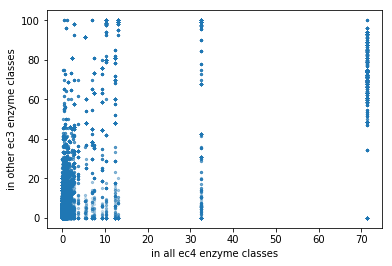

In [7]:


plt.scatter(x=df['toccurance_across_EC4_classes'], 
            y=df['occurance_in_neighbor_EC3_subclasses'],
            s=5,
            alpha=0.2)

plt.xlabel('in all ec4 enzyme classes', fontdict=None, labelpad=None)
plt.ylabel('in other ec3 enzyme classes', fontdict=None, labelpad=None)

Tried adding another axis, but that did not work so well. The third axis also does not separate. I will threshold on two of the variables, see what gets filtered out and then re-plot. This might work as each substrate is plotted many times. For example water occurs sometimes 100% and sometimes much less. If I always filter it out (based it scoring high for some EC) it will also clean up the lower-scoring ec.

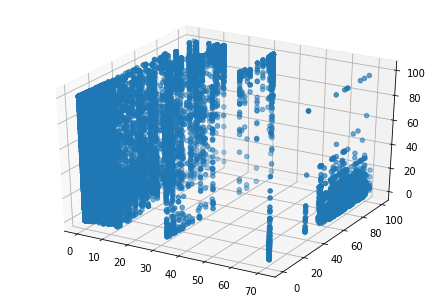

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df['toccurance_across_EC4_classes'], 
            df['occurance_in_neighbor_EC3_subclasses'],
          df['occurance_in_own_EC4_reactions'])

plt.show()

In [9]:
set(df.loc[df['toccurance_across_EC4_classes'] > 3]['substrate'])



{'ATP',
 'GTP',
 'H+',
 'H2O',
 'NAD+',
 'NADH',
 'NADP+',
 'NADPH',
 'O2',
 'S-adenosyl-L-methionine',
 'more'}

In [10]:
set(df.loc[df['occurance_in_neighbor_EC3_subclasses'] > 50]['substrate'])

{'2,6-dichlorophenol indophenol',
 '2,6-dichlorophenolindophenol',
 '2-oxoglutarate',
 "3'-phosphoadenylyl sulfate",
 "3'-phosphoadenylylsulfate",
 'ATP',
 'CoA',
 'DNA',
 'GTP',
 'H+',
 'H2O',
 'H2O2',
 'L-Gln',
 'L-glutamine',
 'NAD+',
 'NADH',
 'NADP+',
 'NADPH',
 'O2',
 'RNA',
 'S-adenosyl-L-methionine',
 '[reduced NADPH-hemoprotein reductase]',
 'acceptor',
 'acetyl-CoA',
 'carbamoyl phosphate',
 'ferricytochrome c',
 'more',
 'oxidized ferredoxin',
 'oxidized methyl viologen',
 'propionate',
 'reduced ferredoxin',
 'reduced ferredoxin [iron-sulfur] cluster',
 'thioredoxin'}

In [12]:
set(df.loc[df['occurance_in_own_EC4_reactions'] > 99]['substrate'])

{'(+)-beta-caryophyllene',
 '(+)-camphor',
 '(+)-cis-3,4-dihydrophenanthrene-3,4-diol',
 '(+)-cis-sabinol',
 '(+)-copalyl diphosphate',
 '(+)-kolavelool',
 '(+)-pulegone',
 '(+)-sabinene',
 "(+,-)-5-[(tert-butylamino)-2'-hydroxypropoxy]-3,4-dihydro-1(2H)-naphthalenone",
 "(-)-4'-demethyl-deoxypodophyllotoxin",
 "(-)-5'-demethoxyyatein",
 "(-)-5'-demethylyatein",
 '(-)-ent-copalyl diphosphate',
 '(-)-jasmonate',
 '(-)-menthol',
 '(-)-secoisolariciresinol',
 '(-)-yatein',
 '(1,4-beta-D-glucosyl)n',
 '(1-hydroxycyclohexan-1-yl)acetyl-CoA',
 '(15S)-15-hydroxy-5,8,11-cis-13-trans-eicosatetraenoate',
 '(1R,2S)-1-Hydroxypropane-1,2,3-tricarboxylate',
 '(2-aminoethyl)phosphonate',
 '(24R)-cholest-5-ene-3beta,24-diol',
 '(2E)-2-(2-methylprop-2-en-1-ylidene)-4-oxopentanedioic acid',
 '(2E,6E)-farnesoate',
 '(2E,6E)-farnesyl diphosphate',
 '(2E,6E,10E,14E)-geranylfarnesyl diphosphate',
 '(2R,3S)-2-methylmalyl-CoA',
 '(2R,3S)-Tartrate',
 '(2S)-2-amino-4-deoxychorismate',
 '(2S)-2-hydroxy-2-methyl-